
# 1. Introduction

This study has been developed for the purposes of the EMPIR project “Metrology for the Factory of the Future” (Met4FoF) -  Activity A1.2.2 of the Work Package 1.Two laboratories in PTB and CEM posses conventional dynamic calibration set-ups for acceleration sensors under test. This section describes different methods for the interlaboratory study on the comparison of measurement results of digital - output acceleration sensor (DUT). The study covered two laboratories with their individual set-ups.  Among in-detailed analysis of the data, three case studies (according to GUM, GUM-S1 and weighted values) were applied as the inputs for the one method of comparison - En values calculation.  The second method of comparison relies on the weighted difference. The analysis required data transformation from time domain signals to the frequency domain, sine approximation and Gaussian error propagation. The selected sensor for acceleration measurements is a three-axial low-g acceleration sensor with digital output, which allows measurements of acceleration in three perpendicular axes. Only a Z-axis acceleration was observed during the study. 

The repository consists of five notebooks containing the whole analysis:
<br>1_Introduction_data_analysis_.ipynb
<br>2_ANOVA_for_experiments.ipynb
<br>3_Case_study_1.ipynb
<br>4_Case_study_2.ipynb
<br>5_Case_study_3.ipynb

## 1.1. State of the art

In conventional dynamic calibration procedures for acceleration sensors, the acceleration used for the sensor input is applied either as **a sinusoidal excitation with a given frequency and amplitude** or as **a singular shock-like excitation characterized by pulse width and intensity**. 
<br>The quantity is then measured by a reference sensor and by the device under test (DUT). The results of DUT are compared to the reference and hence characterized and linked to the SI. In a dynamic calibration situation, the response of the DUT to time-varying input is the major interest. Hence, it is crucial that the mechanical input operates simultaneously and equally on the reference and DUT. Both, the reference and the DUT provide **electrical outputs (typical voltage)** while **the data acquisition electronics** of the system provides **the analogue to digital conversion (ADC).**
In order to connect the reference and the DUT to the ADC system, two analogue channels are needed. In order to get reliable information on the time dependent response, the timing of the data acquisition on the two channels has to be synchronized. This is typically accomplished by provision of a common clock signal to drive the sampling units of the ADC and a common trigger to start (or mark) the beginning of the acquisition. 

## 1.2. The extension of conventional dynamic calibration systems to digital-output sensors 

In a set-up where the DUT is a digital-output sensor,the sampling of the DUT time series is no longer under the control (trigger, clock) of the calibration system. Instead, the DUT comprises its own digitizer unit with a time base independent of the calibration system. In fact, a typical conventional calibration set-up does not provide an input for digital data at all.
The solution to this problem requires two extensions:
1.	A digital acquisition unit (DAU) which is capable to connect to the digital interface of the sensor under calibration and store/transmit the DUT time-series for later analysis
2.	An additional synchronization signal that provides the link between the time-base of the calibration system and the time-base of the DUT.

The concept for the extension of existing facilities for dynamic calibration uses a custom digital acquisition unit microcontroller board with a connected reference time signal for traceable time stamping of acquired data points. This allows for a synchronised data acquisition from the reference measurement and the DUT. 


The selected laboratories posses their set-ups and the calibration items were calibrated in both set-ups.The analysis required transformation from time domain to the frequency domain, where frequencies and corresponding magnitudes and phases were calculated.The measurement conditions were kept according to the laboratory standard conditions. 

Each laboratory submitted HDFT files containing groups:
- EXPERIMENTS - containing 171 files (experiment) corresponding to the sine excitations
- RAWDATA - where data from ADCs (*voltage, absolute time, absolute time uncertainty*)  and sensors (*absolute time, absolute time uncertainty, acceleration, angular velocity, magnetic flux density and temperature*) can be approached during the measurements
- RAWTRANSFERFUNCTION - *this group contains quantities of interest: frequencies, amplitudes, assigned uncertainties of amplitudes, phases,  assigned uncertainties of phases, excitation amplitudes and assigned uncertainties of excitation amplitudes
- REFERENCEDATA - reference data from ADCs and sensors.

Measurement characteristics of DUT are given in the Table 1 below
    
| <b>PTB<b> | Sensor | Internal ADC |
| --- | --- | --- |
| <b>Name<b> | MPU 9250| STM 32 Internal ADC |
| <b>ID<b>  | 535035904 | 535038464 |
| <b>Quantity<b>  | Z Acceleration | Voltage  @CH1 |
| <b>Unit<b>  | $\frac{m}{s^{2}}$ | V |    
| <b>Resolution<b>  | 65536,0 (16-bit) | 4096,0 (12-bit) |
| <b>Min. scale<b>  | -156,91439819335938 $\frac{m}{s^{2}}$  | -10 V |
| <b>Max. scale<b>  | 156,90960693359375 $\frac{m}{s^{2}}$  | 10 V |
    
| <b>CEM<b> | Sensor | Internal ADC |
| --- | --- | --- |
| <b>Name<b> | MPU 9250| STM 32 Internal ADC |
| <b>ID<b>  | 3167420416 | 31674422976 |
| <b>Quantity<b>  | Z Acceleration | Voltage  @CH1 |
| <b>Unit<b>  | $\frac{m}{s^{2}}$ | V |    
| <b>Resolution<b>  | 65536,0 (16-bit) | 4096,0 (12-bit) |
| <b>Min. scale<b>  | -156,91439819335938 $\frac{m}{s^{2}}$  | -10 V |
| <b>Max. scale<b>  | 156,90960693359375 $\frac{m}{s^{2}}$  | 10 V |
    
    
The calibration range of the study was selected in accordance with the current measurement capabilities of the participating laboratories. 

In [89]:

import h5py
import numpy as np
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import scipy.stats as stats
#conda install -c conda-forge miktex in command prompt
import seaborn as sns
from ipywidgets import widgets, Layout#this is optionally, must be installed 
from IPython import display #this is optionally
import warnings
from scipy import stats

In [90]:
#FOR LATEX -takes longer to run plots

plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']# all text in blots bold
#plt.rc('text', usetex=True)# for figure export 
plt.rc('text', usetex=False)# use tex for image export
PLTSCALFACTOR =1.5# change this to scale all plots labels (3 is good for export on 4k screan)
SMALL_SIZE = 12 * PLTSCALFACTOR
MEDIUM_SIZE = 15 * PLTSCALFACTOR
BIGGER_SIZE = 18 * PLTSCALFACTOR

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['lines.linewidth'] = PLTSCALFACTOR

# 2.Extract the data

Data for ILC comparison is extracted from the HDF5 files separately for PTB and CEM. The extracted data is sorted by frequency at the end of the Notebook and saved into Excel file.

In [91]:
def extract_data(filename, sensor_ID):
    #explore the HDF5 file, folders and subfolders
    with h5py.File(filename,'r') as f:
        base_items=list(f.items())
        print("\nItems in directory", base_items)
        rawtransfer=f.get("RAWTRANSFERFUNCTION")
        rawtransfer_items=list(rawtransfer.items())
        print("\nItems in reference", rawtransfer_items)
        subgroup=rawtransfer.get("/RAWTRANSFERFUNCTION/"+sensor_ID)
        subgroup_items=list(subgroup.items())
        print("\n"+sensor_ID+"items:",subgroup_items)
        subgroup_acceleration=subgroup.get("/RAWTRANSFERFUNCTION/"+sensor_ID+"/Acceleration")
        subgroup_acceleration_items=list(subgroup_acceleration.items())
        print("\nAcceleration items:",subgroup_acceleration_items)
        subgroup_acceleration_5mem=subgroup.get("/RAWTRANSFERFUNCTION/"+sensor_ID+"/Acceleration/Acceleration")
        subgroup_acceleration_5mem_items=list(subgroup_acceleration_5mem.items())
        print("\nAcceleration items_5members:", subgroup_acceleration_5mem_items)
        frequency=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_ID+"/Acceleration/Acceleration/Excitation_frequency")
        frequency_items=list(frequency.items())
        print("\nFrequency", frequency_items)
        magnitude=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_ID+"/Acceleration/Acceleration/Magnitude")
        magnitude_items=list(magnitude.items())
        print("\nMagnitude", magnitude_items)
        phase=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_ID+"/Acceleration/Acceleration/Phase")
        phase_items=list(magnitude.items())
        print("\nPhase", phase_items)
        
        
        #extract frequencies, magnitude, phase, uncertainties and all excitation parameters
        frequency_values=np.array(frequency.get("value"))
        magnitude_values=np.array(magnitude.get("value"))
        magnitude_uncertainties=np.array(magnitude.get("uncertainty"))
        phase_values=np.array(phase.get("value"))
        phase_uncertainties=np.array(phase.get("uncertainty"))
        excitation_freq_items=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_ID+"/Acceleration/Acceleration/Excitation_frequency")
        excitation_freq=np.array(excitation_freq_items.get("value"))
        excitation_amp_items=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_ID+"/Acceleration/Acceleration/Excitation_amplitude")
        excitation_amp=np.array(excitation_amp_items.get("value"))
        excitation_amp_uncertainty=np.array(excitation_amp_items.get("uncertainty"))
        
        #join all necessary data in 2D array
        total_array=np.stack((frequency_values,magnitude_values,magnitude_uncertainties,phase_values, phase_uncertainties,excitation_freq,excitation_amp,excitation_amp_uncertainty), axis=1)
        print("\nArray dimensions:", total_array.shape)
        column_names=["Frequency in Hz", r"$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",r"$U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$", r"$\varphi(\omega)$ in $rad$", r"$U_{\varphi(\omega)}$ in $rad$","Excitation_freq in Hz",r"$A_{excit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",r"$U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"]
        whole_dataset=pd.DataFrame(total_array, columns=column_names)
        f.close()
       
        return whole_dataset

In [92]:
#whole_dataset_PTB = extract_data('BMA280PTB.hdf5',"0x1fe40000_BMA_280")
whole_dataset_PTB = extract_data('MPU9250PTB_v5.hdf5',"0x1fe40000_MPU_9250")


Items in directory [('EXPERIMENTS', <HDF5 group "/EXPERIMENTS" (1 members)>), ('RAWDATA', <HDF5 group "/RAWDATA" (2 members)>), ('RAWTRANSFERFUNCTION', <HDF5 group "/RAWTRANSFERFUNCTION" (1 members)>), ('REFERENCEDATA', <HDF5 group "/REFERENCEDATA" (2 members)>)]

Items in reference [('0x1fe40000_MPU_9250', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250" (1 members)>)]

0x1fe40000_MPU_9250items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration" (1 members)>)]

Acceleration items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration/Acceleration" (11 members)>)]

Acceleration items_5members: [('DUT_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration/Acceleration/DUT_Phase" (2 members)>), ('DUT_SNYNC_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration/Acceleration/DUT_SNYNC_Phase" (2 members)>), ('DUT_amplitude', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/A

In [93]:
whole_dataset_PTB.head(2)

Frequency in Hz  \
0             10.0   
1             12.5   

   $|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           1.019554             
1                                           1.019093             

   $U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           0.003273                 
1                                           0.004047                 

   $\varphi(\omega)$ in $rad$  $U_{\varphi(\omega)}$ in $rad$  \
0                   -0.094684                        0.003022   
1                   -0.118820                        0.006455   

   Excitation_freq in Hz  \
0                   10.0   
1                   12.5   

   $A_{excit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                              2.739           
1                                              2.744           

   $U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  
0                                           0.004891           
1                                           0.007312

In [94]:
#whole_dataset_PTB[[r"$\varphi(\omega)$ in $rad$"]] = whole_dataset_PTB[[r"$\varphi(\omega)$ in $rad$"]]-np.pi
whole_dataset_PTB.head(2)

Frequency in Hz  \
0             10.0   
1             12.5   

   $|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           1.019554             
1                                           1.019093             

   $U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           0.003273                 
1                                           0.004047                 

   $\varphi(\omega)$ in $rad$  $U_{\varphi(\omega)}$ in $rad$  \
0                   -0.094684                        0.003022   
1                   -0.118820                        0.006455   

   Excitation_freq in Hz  \
0                   10.0   
1                   12.5   

   $A_{excit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                              2.739           
1                                              2.744           

   $U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  
0                                           0.004891           
1                                           0.007312

In [95]:
#whole_dataset_CEM = extract_data('BMA280CEM.hdf5',"0xbccb0000")
whole_dataset_CEM = extract_data('MPU9250CEM_v5.hdf5',"0xbccb0000_MPU_9250")


Items in directory [('EXPERIMENTS', <HDF5 group "/EXPERIMENTS" (1 members)>), ('RAWDATA', <HDF5 group "/RAWDATA" (2 members)>), ('RAWTRANSFERFUNCTION', <HDF5 group "/RAWTRANSFERFUNCTION" (1 members)>), ('REFERENCEDATA', <HDF5 group "/REFERENCEDATA" (2 members)>)]

Items in reference [('0xbccb0000_MPU_9250', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250" (1 members)>)]

0xbccb0000_MPU_9250items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration" (1 members)>)]

Acceleration items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration/Acceleration" (11 members)>)]

Acceleration items_5members: [('DUT_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration/Acceleration/DUT_Phase" (2 members)>), ('DUT_SNYNC_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration/Acceleration/DUT_SNYNC_Phase" (2 members)>), ('DUT_amplitude', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/A

In [96]:
whole_dataset_CEM.head(2)

Frequency in Hz  \
0             80.0   
1            250.0   

   $|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                                NaN             
1                                           0.643003             

   $U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                                NaN                 
1                                           0.000891                 

   $\varphi(\omega)$ in $rad$  $U_{\varphi(\omega)}$ in $rad$  \
0                         NaN                             NaN   
1                    0.766181                        0.002897   

   Excitation_freq in Hz  \
0                   80.0   
1                  250.0   

   $A_{excit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                                NaN           
1                                         126.497513           

   $U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  
0                                                NaN           
1                                           0.125687

Phase data for CEM must be reverted:

In [97]:
whole_dataset_CEM[[r"$\varphi(\omega)$ in $rad$"]] = whole_dataset_CEM[[r"$\varphi(\omega)$ in $rad$"]]-np.pi
whole_dataset_CEM.head(2)

Frequency in Hz  \
0             80.0   
1            250.0   

   $|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                                NaN             
1                                           0.643003             

   $U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                                NaN                 
1                                           0.000891                 

   $\varphi(\omega)$ in $rad$  $U_{\varphi(\omega)}$ in $rad$  \
0                         NaN                             NaN   
1                   -2.375412                        0.002897   

   Excitation_freq in Hz  \
0                   80.0   
1                  250.0   

   $A_{excit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                                NaN           
1                                         126.497513           

   $U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  
0                                                NaN           
1                                           0.125687

# 3.Data analysis

The study consisted of ten measurement cycles for PTB and nine measurement cycles for CEM in the frequency range of (10.0 - 250.0)Hz. Each measurement cycle contained seventeen calibration points within the selected frequency range. The individual measurements in the one cycle are called “experiments”. Each calibration point in one cycle was quantified in terms of estimated values and expanded uncertainties of magnitude and phase.  These values arose from the sine-fitting and conversion
of time-domain signals into frequency domain. The provided data sets also include the excitation amplitude values, whose variations from the targeted values are known and not considered.  The CEM’s set-up always starts measurement at frequencies of 80.0 Hz and 250.0 Hz respectively, before targeting the calibration point at 10.0Hz. In particular, the magnitude and phase values originating from this characteristic of the CEM’s set-up have not been considered.

## 3.1 Introduction plots

In [98]:
def plot_dataset(dataset,name):
    #%matplotlib qt
    
    plt.figure(figsize=(15,20))
    plt.subplot(211)
    plt.plot(dataset[r"$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"])
    plt.ylabel(r"$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$" )#fontsize=14)
    plt.xlabel("Experiments")#fontsize=14)
    plt.title(name) #fontsize=14)

    plt.subplot(212)
    plt.plot(np.rad2deg(dataset[r"$\varphi(\omega)$ in $rad$"].values))
    plt.ylabel(r"$\varphi(\omega)$ in$^\circ$")#, fontsize=14)
    plt.xlabel("Experiments")#,fontsize=14)

    plt.show()

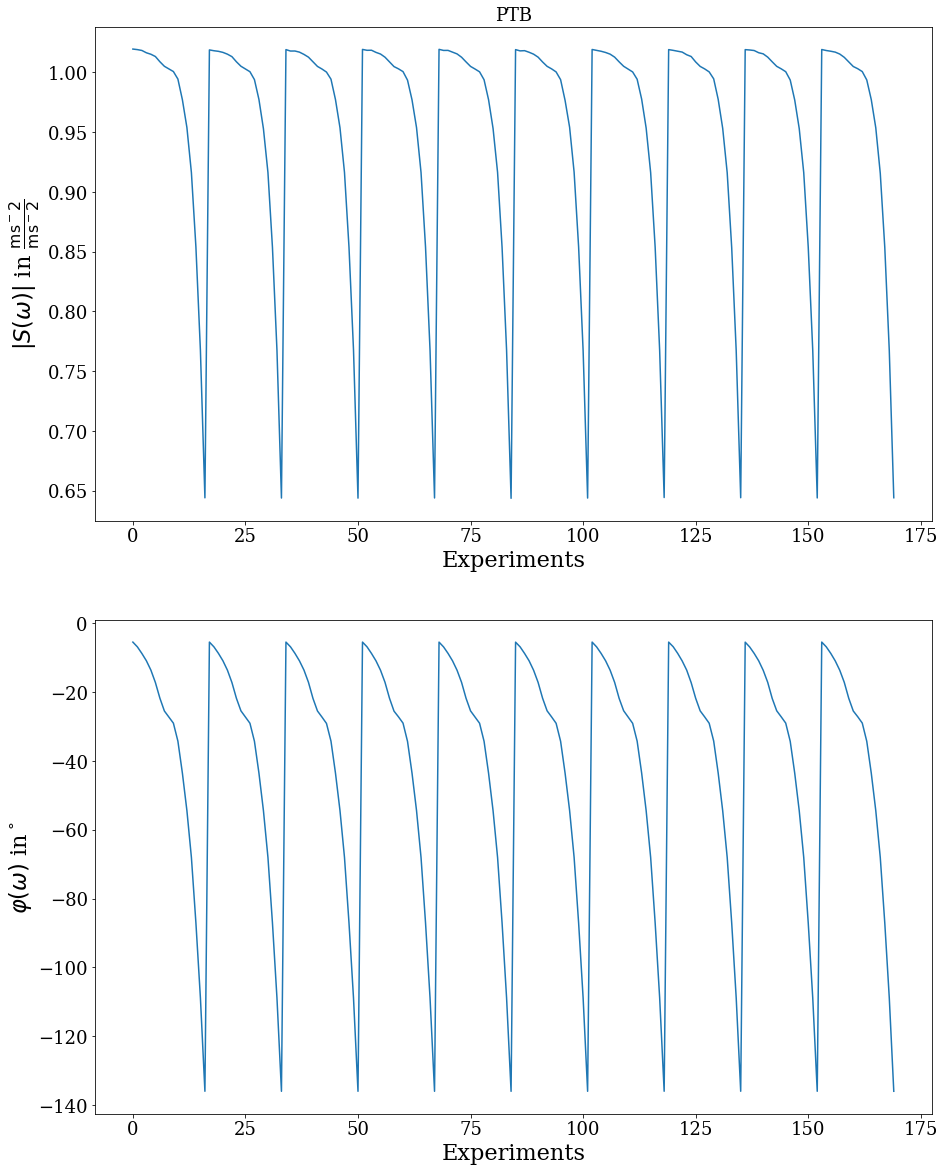

In [99]:
plot_dataset(whole_dataset_PTB,"PTB")

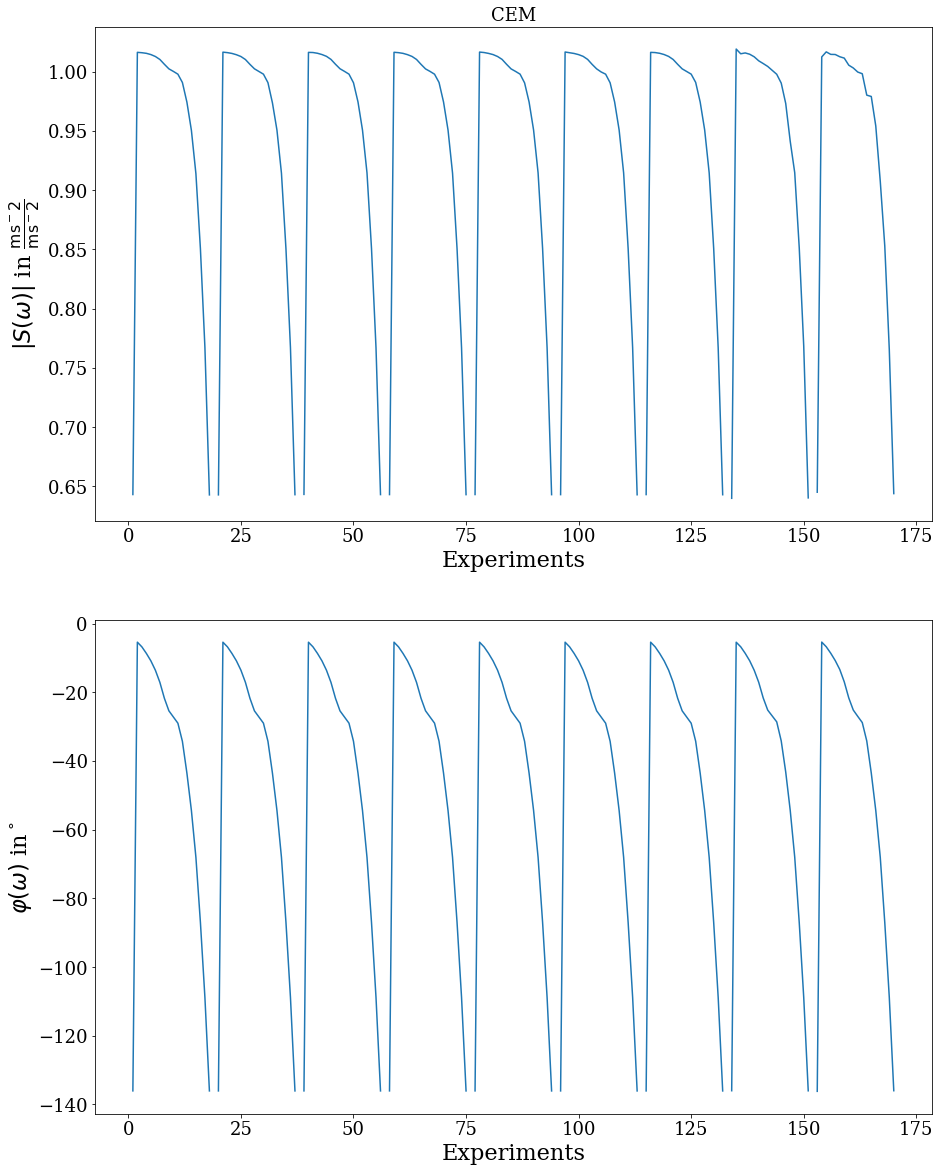

In [100]:
plot_dataset(whole_dataset_CEM,"CEM")
# peaks are individual behaviour, the system at CEM works in a way that starts with the freq of 80 Hz.

Graphs show measurement cycles, where each poing on x-axis corresponds to the one experiment. PTB conducted 10 measurement cycles, resulting in ten values for magnitude and phase at each calibration point (frequency in a range from 10.0 Hz and 250 Hz). Cycles in CEM's dataset start with 80.0 Hz and 250.0 Hz instead of 10.0 Hz, which is the consequence of the current set-up. These starting points are deleted in order to compare the cycles in a range from 10.0 Hz and 250 Hz and the total number of measurement cycles for the corrected CEM data is 9, meaning that there are nine values for magnitude and phase at each calibration point.

In [101]:
delete_rows=[]

for k in range(0,171,19):
    i=k
    j=k+1
    delete_rows.append(i)
    delete_rows.append(j)
whole_dataset_CEM_new=whole_dataset_CEM.drop(axis=0,index=delete_rows)

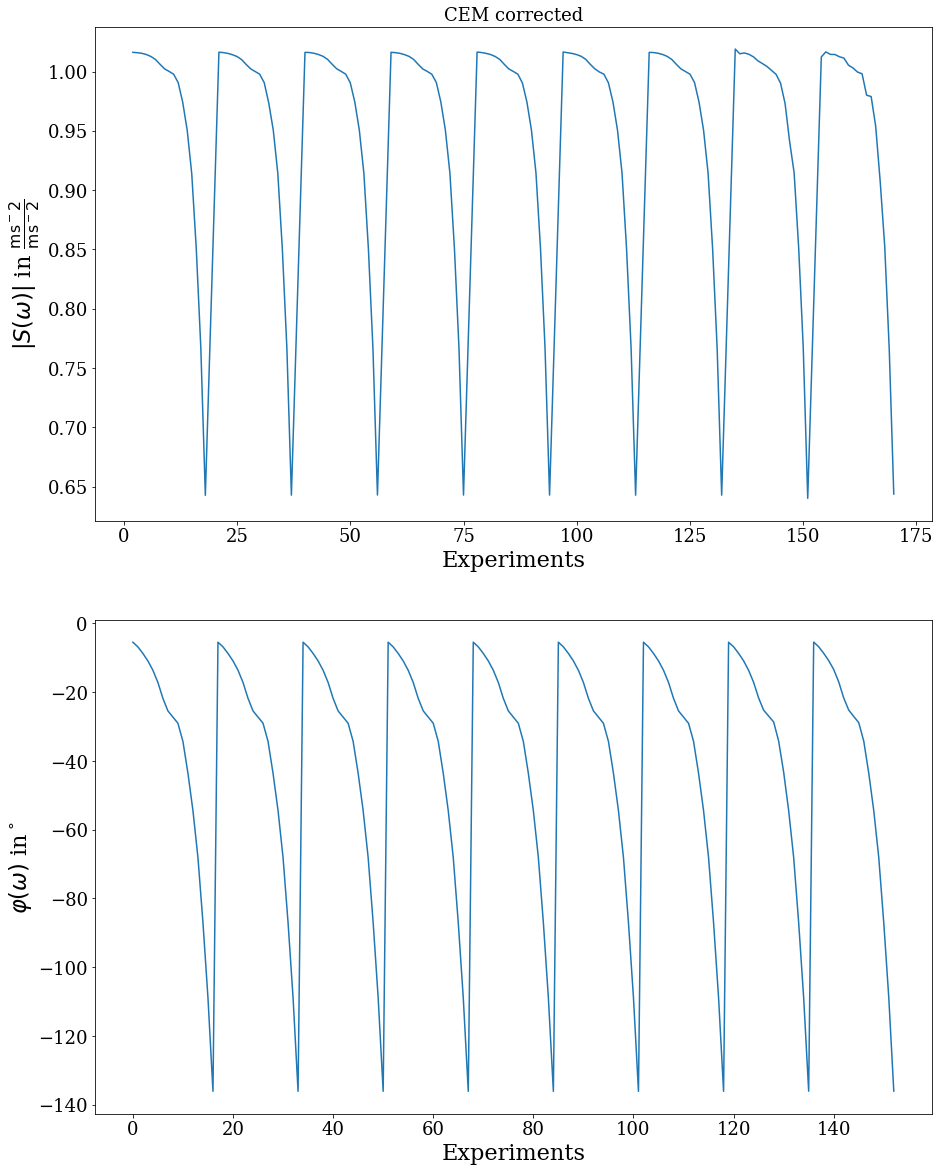

In [102]:
plot_dataset(whole_dataset_CEM_new,"CEM corrected")


The calibration procedure for PTB and CEM was conducted in a similar way and the further analysis covers the examination of changes in mangitudes and phases on different frequencies. The first calibration point is at 10 Hz because the shaker in the calibration system should be bigger in order to achieve lower frequencies. Additionally, some variations are present for excitation amplitude values because it is hard to achieve the targeted values (usually vary around 1%).

In [103]:
def split_data_by_frequencies(dataset):
    dict_of_frequencies=dict(iter(dataset.groupby('Frequency in Hz')))
    return dict_of_frequencies
    #list_of_frequencies=np.array([10,12.5,16,20,25,31.5,40,46.7,50,53.3,63,80,100,125,160,200,250])

In [104]:
#check if all frequencies are the same
PTB_separated_by_freq=split_data_by_frequencies(whole_dataset_PTB)
CEM_separated_by_freq=split_data_by_frequencies(whole_dataset_CEM)
CEM_separated_by_freq_new=split_data_by_frequencies(whole_dataset_CEM_new)
print("Frequencies - PTB:",PTB_separated_by_freq.keys())
print("Frequencies - CEM:",CEM_separated_by_freq.keys())

Frequencies - PTB: dict_keys([10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0])
Frequencies - CEM: dict_keys([10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0])


In [105]:
PTB_separated_by_freq.get(10).head(1)

Frequency in Hz  \
0             10.0   

   $|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           1.019554             

   $U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           0.003273                 

   $\varphi(\omega)$ in $rad$  $U_{\varphi(\omega)}$ in $rad$  \
0                   -0.094684                        0.003022   

   Excitation_freq in Hz  \
0                   10.0   

   $A_{excit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                              2.739           

   $U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  
0                                           0.004891

In [106]:
CEM_separated_by_freq_new.get(10).head(1)

Frequency in Hz  \
2             10.0   

   $|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
2                                           1.016209             

   $U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
2                                           0.004893                 

   $\varphi(\omega)$ in $rad$  $U_{\varphi(\omega)}$ in $rad$  \
2                   -0.094907                        0.001665   

   Excitation_freq in Hz  \
2                   10.0   

   $A_{excit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
2                                           2.754331           

   $U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  
2                                            0.00586

In [107]:
q_names=list(PTB_separated_by_freq.get(10).columns)

The quantities of interest from the dictionaries are $|S(\omega)|$, $\varphi(\omega)$, with assigned expanded uncertainties ${U_{|S(\omega)|}},{U_{\varphi(\omega)}}$.
 
The estimated values in every experiment were calculated as mean values, while the assigned error bars correspond to the standard uncertainties according to GUM, representing the Gaussian error propagation. The following plots show magnitude values  and phase values for all measurements done at frequencies within the calibration range.
The interval of  $|S(\omega)|-u _{|S(\omega)|}$ and $|S(\omega)|+u_{|S(\omega)|}$   is plotted for each cycle and frequency, where $u_{|S(\omega)|}$ is calculated as   $\frac{U _{|S(\omega)|}}{2}$.
The interval of  $\varphi(\omega)-u _{\varphi(\omega)}$ and $\varphi(\omega)+u_{\varphi(\omega)}$   is plotted for each cycle and frequency, where $u_{\varphi(\omega)}$ is calculated as   $\frac{U _{\varphi(\omega)}}{2}$.

In [108]:
def plot_x_plus_minus_sigma(dictionary,names):
    range_mag,range_ph,index_mag=np.empty(len(dictionary.values())),np.empty(len(dictionary.values())),np.empty(len(dictionary.values()))
    index_ph=np.empty(len(dictionary.values()))
    for i,val in enumerate(dictionary.values()):
        data_dict_mag = {}
        data_dict_mag['cycle'] =list(range(len(val)))
        data_dict_mag['lower'] = val[r"$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"].values-val[r"$U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"].values/2
        data_dict_mag['upper'] = val[r"$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"].values+val[r"$U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"].values/2
        dataset_mag = pd.DataFrame(data_dict_mag)
        range_mag[i]=(dataset_mag['upper']-dataset_mag['lower']).max()
        index_mag[i]=(dataset_mag['upper']-dataset_mag['lower']).idxmax()
        
        data_dict_phase = {}
        data_dict_phase['cycle'] =list(range(len(val)))
        data_dict_phase['lower'] = val[r"$\varphi(\omega)$ in $rad$"].values-val[r"$U_{\varphi(\omega)}$ in $rad$"].values/2
        data_dict_phase['upper'] = val[r"$\varphi(\omega)$ in $rad$"].values+val[r"$U_{\varphi(\omega)}$ in $rad$"].values/2
        dataset_phase = pd.DataFrame(data_dict_phase)
        range_ph[i]=(dataset_phase['upper']-dataset_phase['lower']).max()
        index_ph[i]=(dataset_phase['upper']-dataset_phase['lower']).idxmax()

        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)

        for lower,upper,y in zip(dataset_mag['lower'],dataset_mag['upper'],range(len(dataset_mag))):
            plt.plot((lower,upper),(y,y),'ro-',color='orange')
        plt.yticks(range(len(dataset_mag)),list(dataset_mag['cycle']))
        plt.title(str(val[names[0]].values[0])+" Hz")
        plt.xlabel(r"$|S(\omega)|$ in $\frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$", fontsize=14)
        plt.ylabel("Experiment",fontsize=14)

        plt.subplot(1,2,2)
        for lower,upper,y in zip(dataset_phase['lower'],dataset_phase['upper'],range(len(dataset_phase))):
            plt.plot((np.rad2deg(lower),np.rad2deg(upper)),(y,y),'ro-',color='orange')
        plt.yticks(range(len(dataset_phase)),list(dataset_phase['cycle']))
        plt.title(str(val[names[0]].values[0])+" Hz")
        plt.xlabel(r"$\varphi(\omega)$ in $^\circ$", fontsize=14)
        plt.ylabel("Experiment",fontsize=14)

    plt.show()
    range_mag=pd.DataFrame(range_mag,index=[10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0],columns=["Magntiude range, [m s^-2/m s^-2]"])
    range_ph=pd.DataFrame(range_ph,index=[10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0],columns=["Phase range, [rad]"])
    index_mag=pd.DataFrame(index_mag,index=[10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0],columns=["Index_M"])
    index_ph=pd.DataFrame(index_ph,index=[10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0],columns=["Index_Ph"])
    
    return range_mag,range_ph,index_mag,index_ph

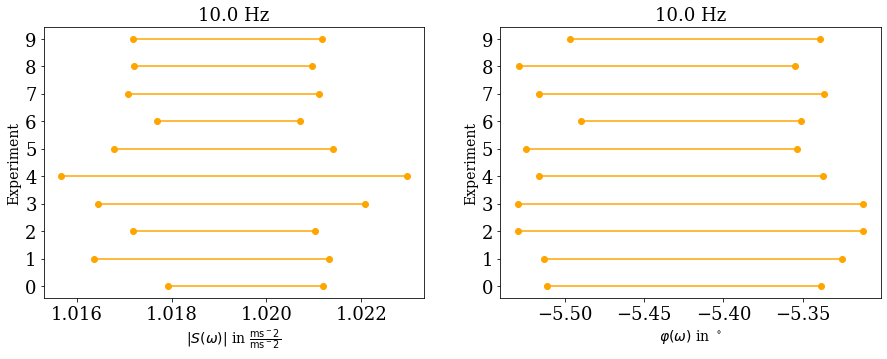

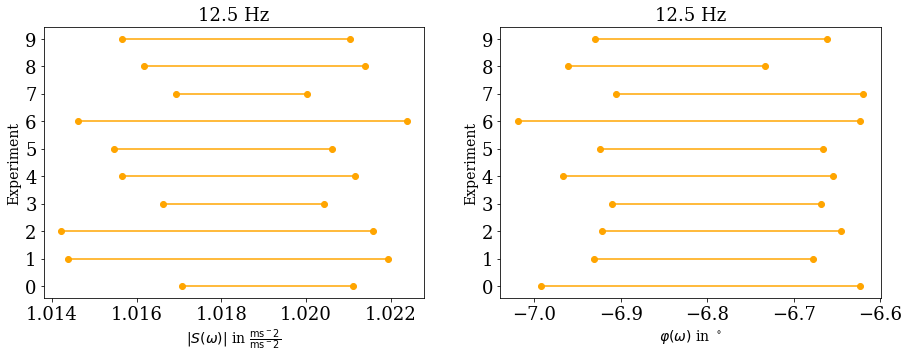

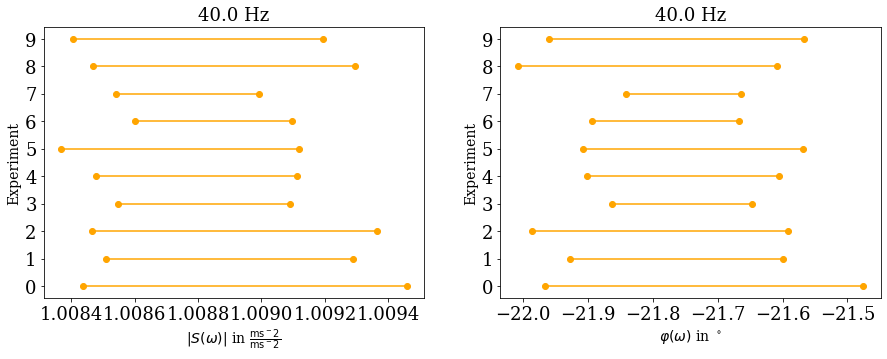

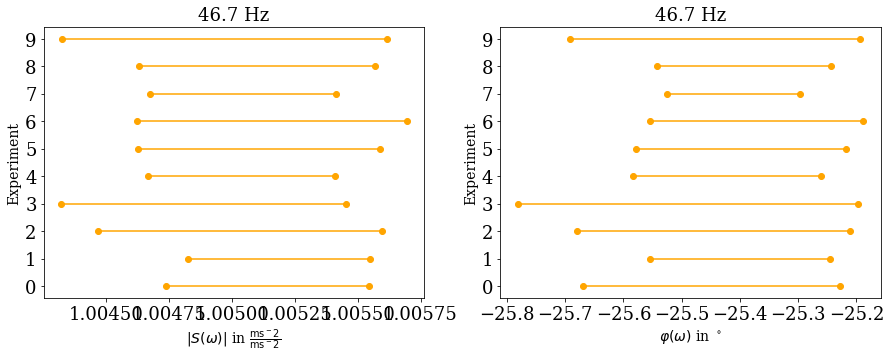

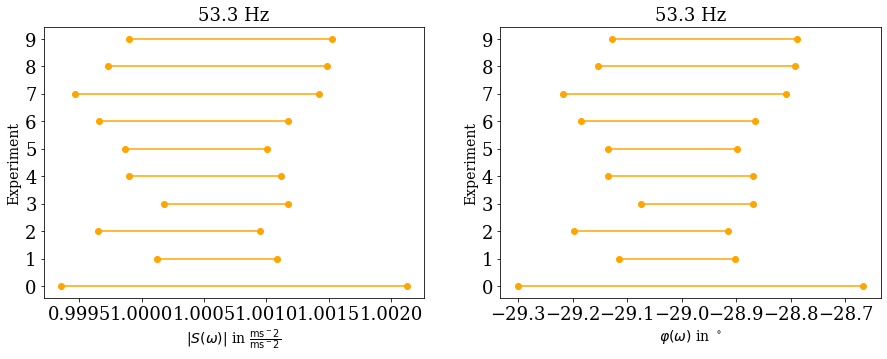

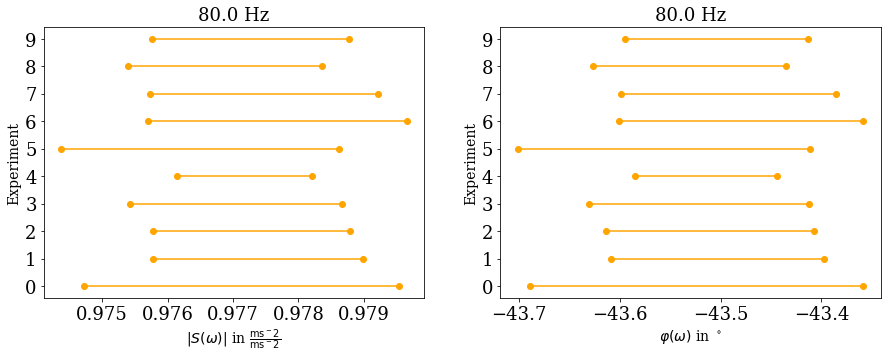

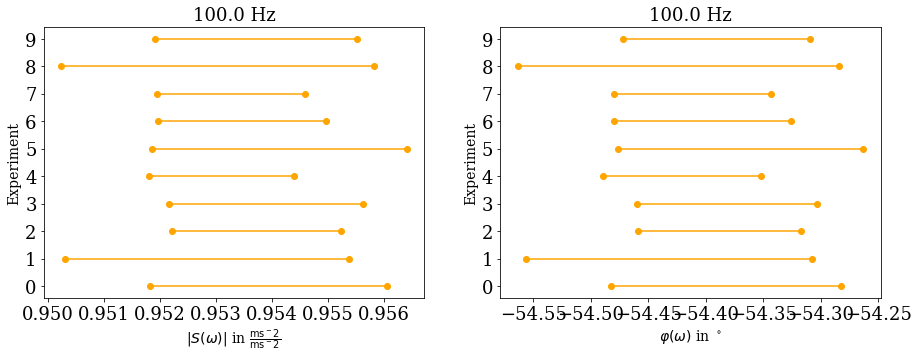

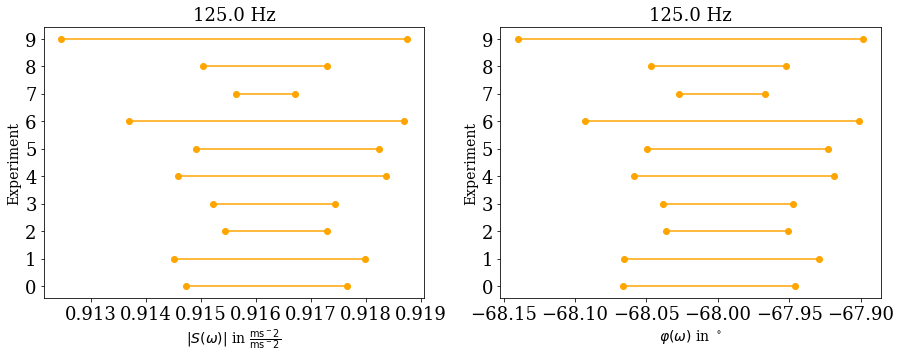

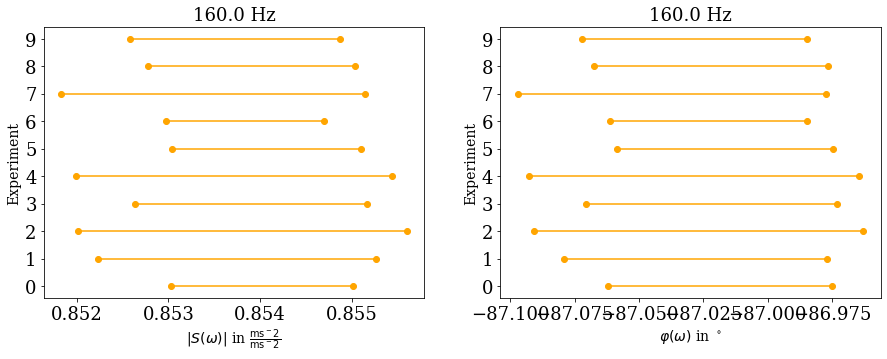

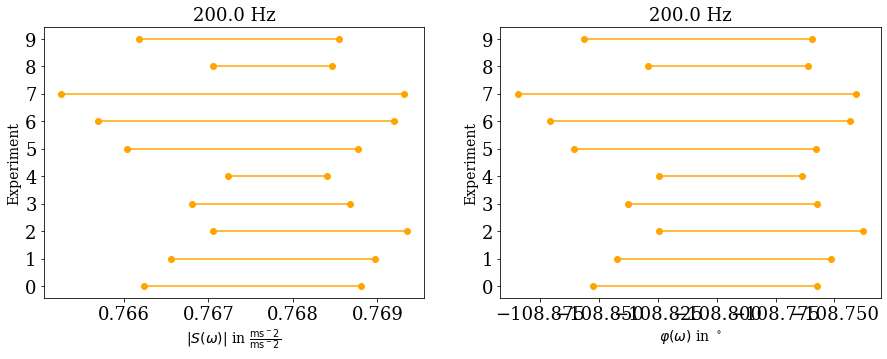

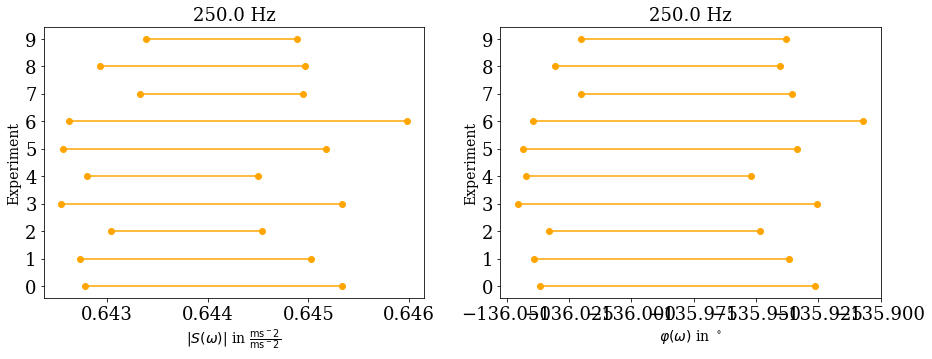

In [109]:
range_mag_PTB,range_ph_PTB,index_mag_PTB,index_ph_PTB=plot_x_plus_minus_sigma(PTB_separated_by_freq,q_names)

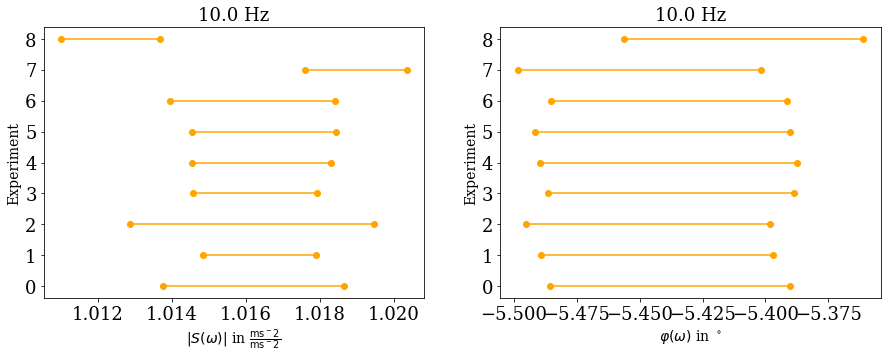

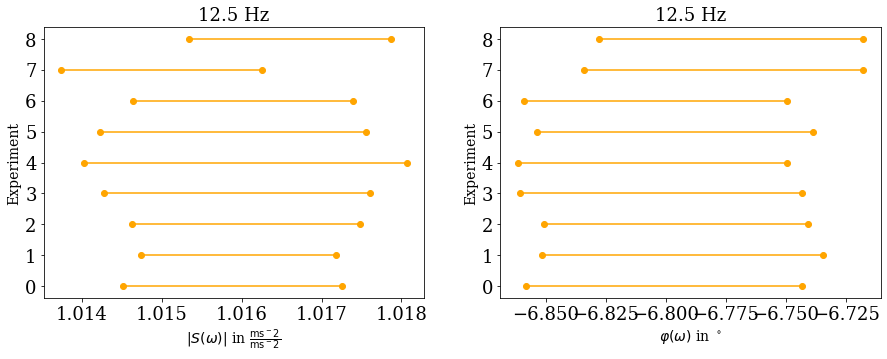

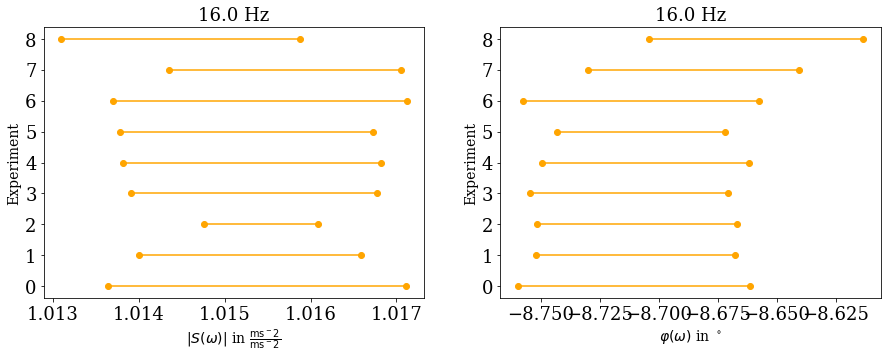

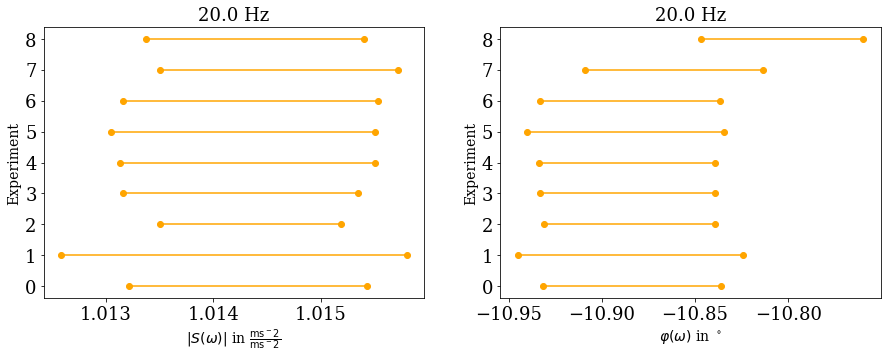

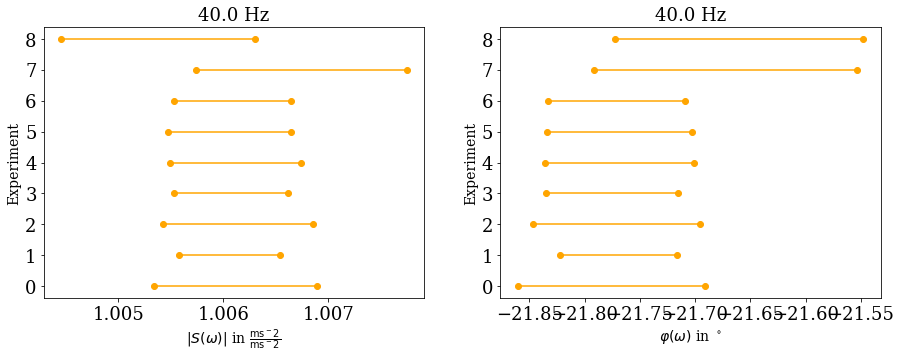

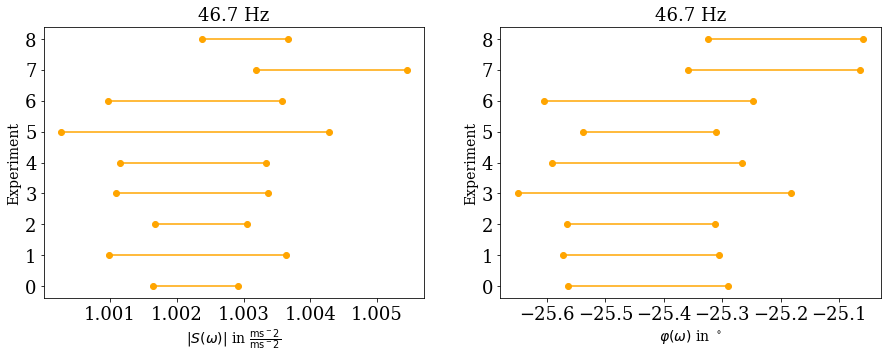

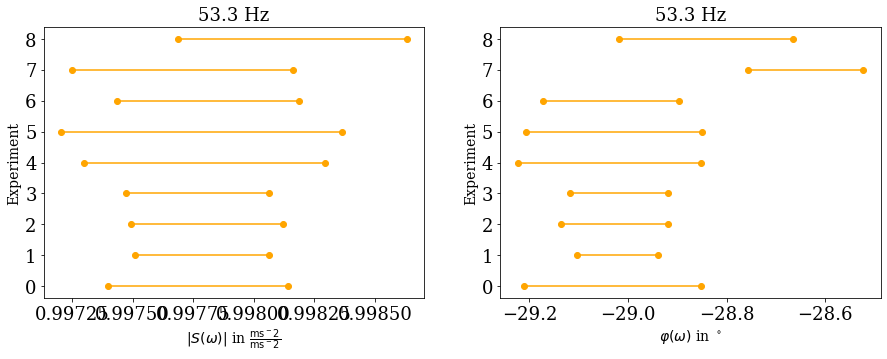

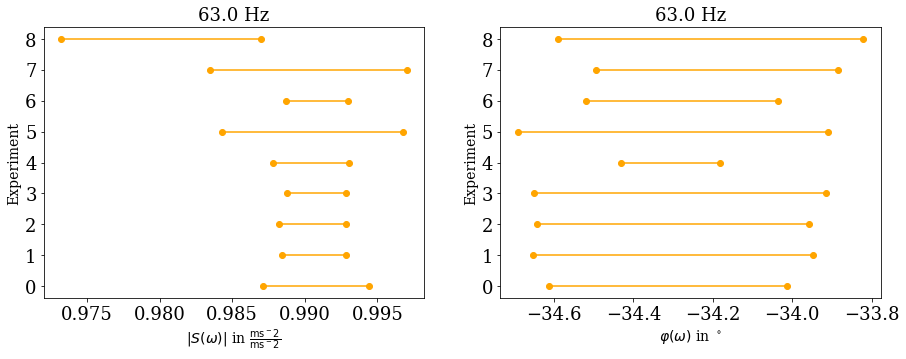

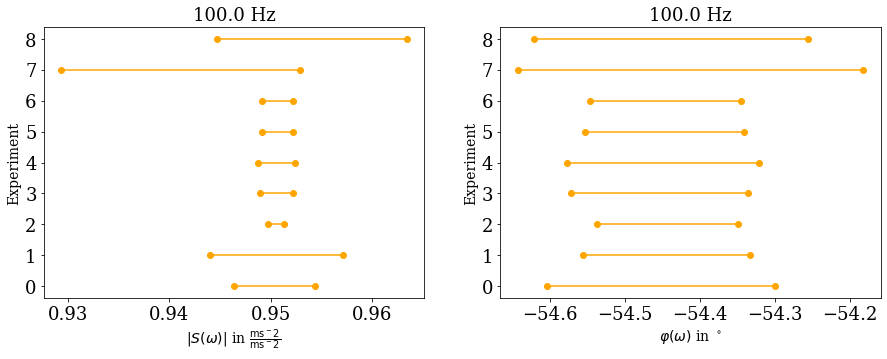

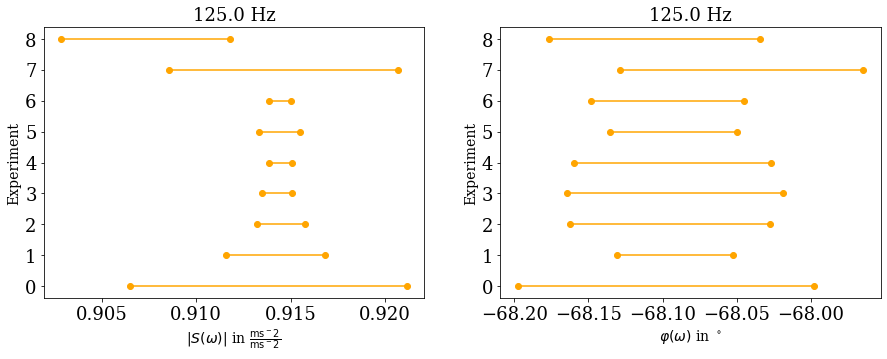

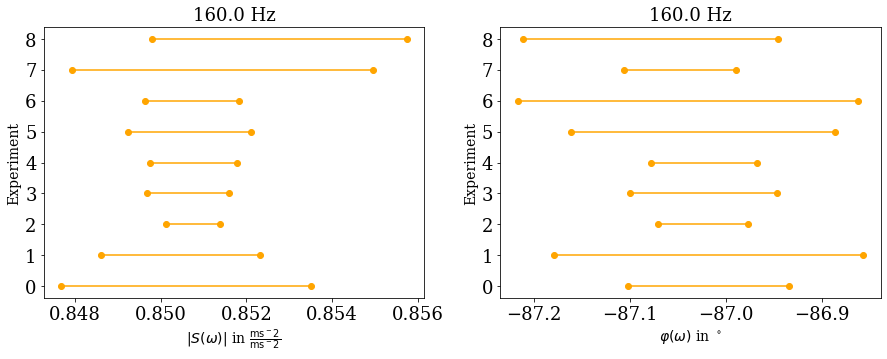

In [110]:
range_mag_CEM,range_ph_CEM,index_mag_CEM,index_ph_CEM=plot_x_plus_minus_sigma(CEM_separated_by_freq_new,q_names)

In [111]:
indices_PTB=pd.concat([index_mag_PTB, index_ph_PTB],axis=1) #indices of experiments of the highest uncert.
indices_CEM=pd.concat([index_mag_CEM, index_ph_CEM],axis=1) #indices of experiments of the highest uncert.

When analyzing the sequence of experiments at which the highest uncertainties occur, it cannot be said that one experiment is extremly dominant or unstable. However, when analyzing both laboratories, at some frequencies the highest uncertainties for the magnitude were detected in the same experiment as the highest uncertainties of the phases. This can be a consequence of the common source of error for both quantities.

In the next plots, the estimated values in every experiment were calculated as mean values, while the assigned error bars correspond to the standard uncertainties according to GUM, representing the Gaussian error propagation. The plots show magnitude values and phase values  for all measurements done at frequencies within the calibration range. The results indicate that the magnitude values obtained by PTB’s calibration process are higher at each calibration point than those obtained by the CEM’s.   


When accompanying standard uncertainties are added, magnitude values are completely distinguishable in the frequency range (31.5 - 46.7) Hz and at 53.3 Hz while other results are in a good agreement.  The highest uncertainties of magnitudes have been detected and compared,  as it follows:  (12.5 - 20.0) Hz - PTB’s setup shows higher uncertainties than CEM, (40.0 - 50.0) Hz - CEM’s setup shows higher uncertainties than PTB’s and (63.0 - 250.0)Hz - CEM’s setup shows higher uncertainties than PTB’s.  In general, except for calibration points at 31.5 Hz and 53.3 Hz, CEM’s set up provides higher magnitude uncertainties at frequencies higher than 25.0 Hz.  The standard uncertainty at 10.0 Hz for CEM’s set-up in this case can be a consequence of reaching the values of 80.0 Hz and 250.0 Hz before each measurement cycle, which brings some discrepancies in stability of the system at the beginning of a measurement procedure. On the other hand, high standard uncertainty values at low frequencies for PTB’s set-up might be caused by the mechanical nature of the system.

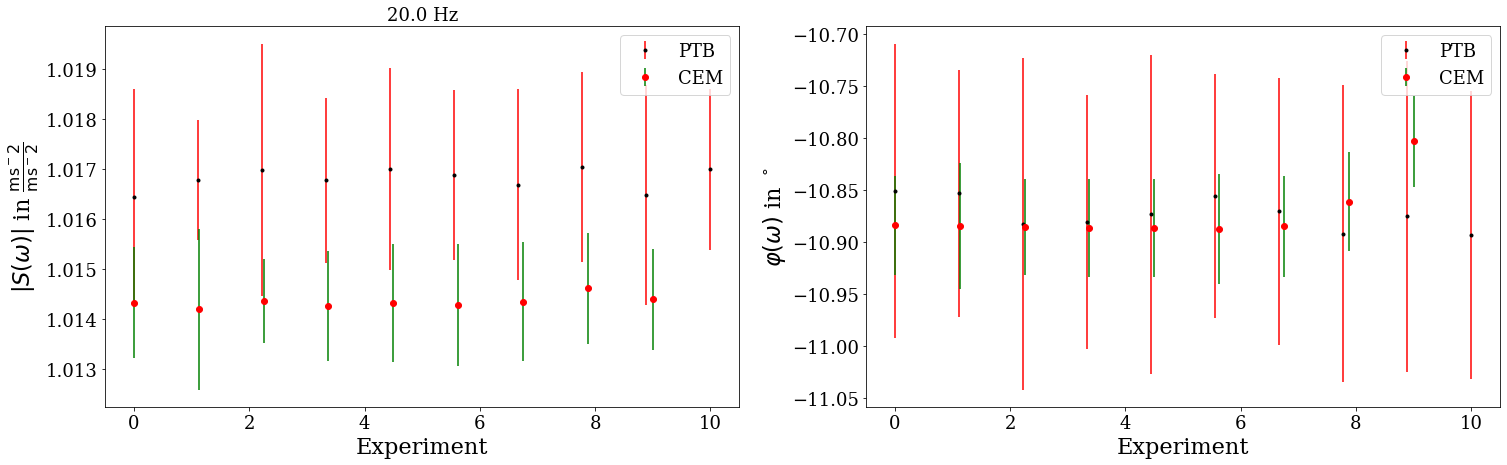

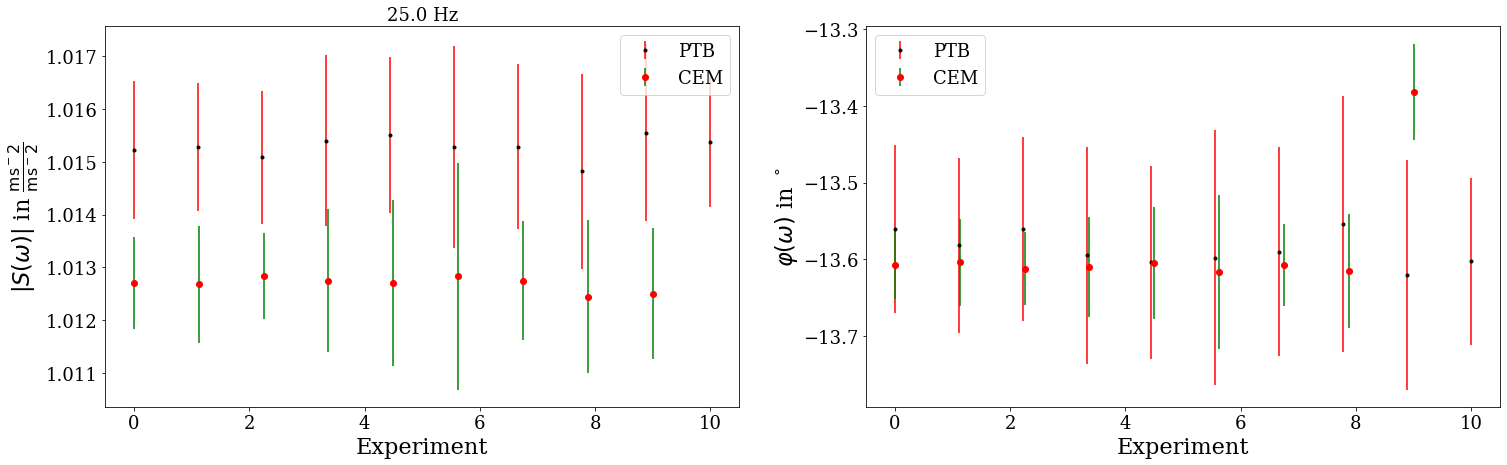

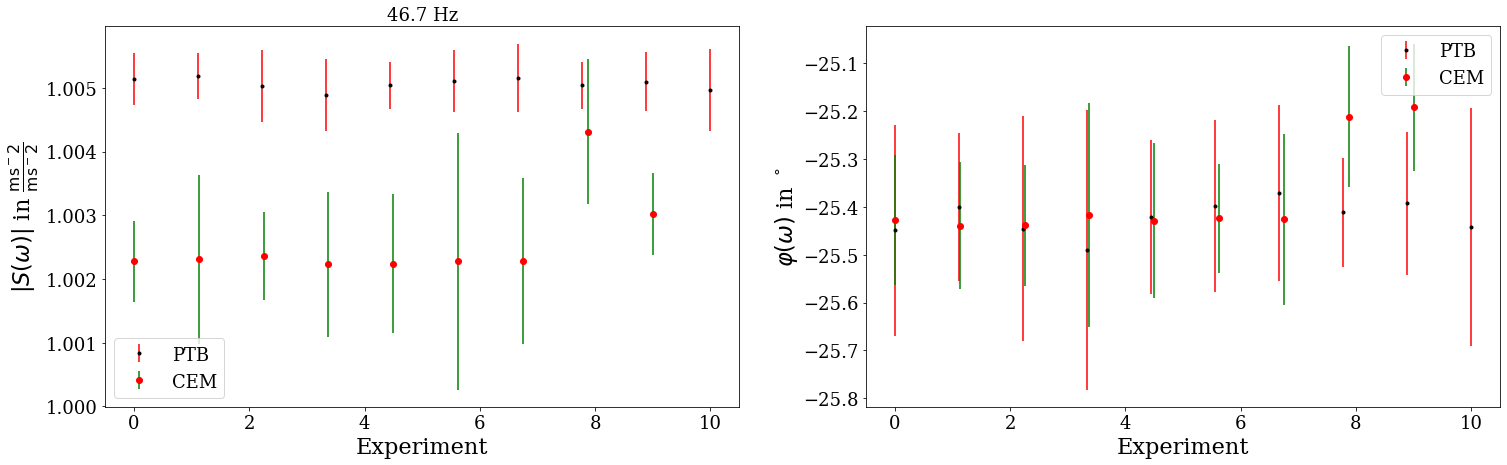

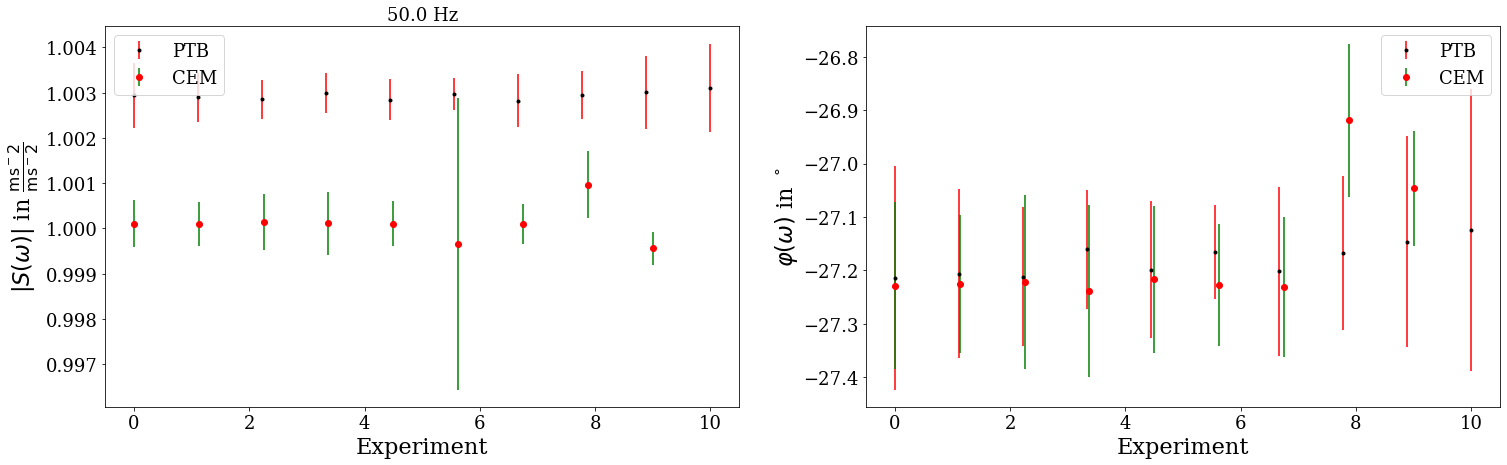

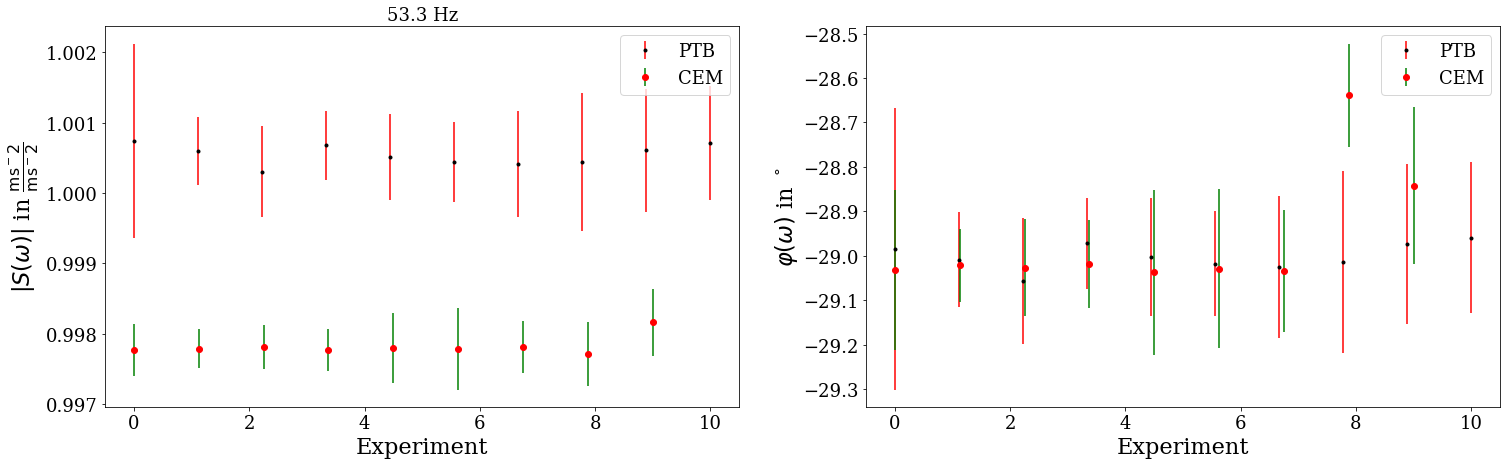

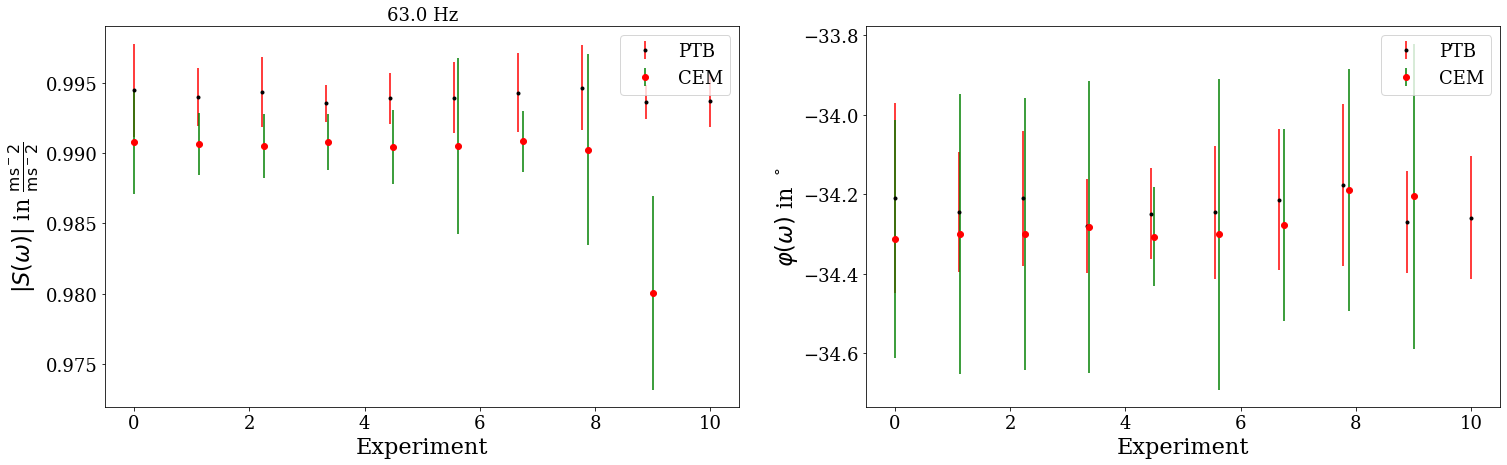

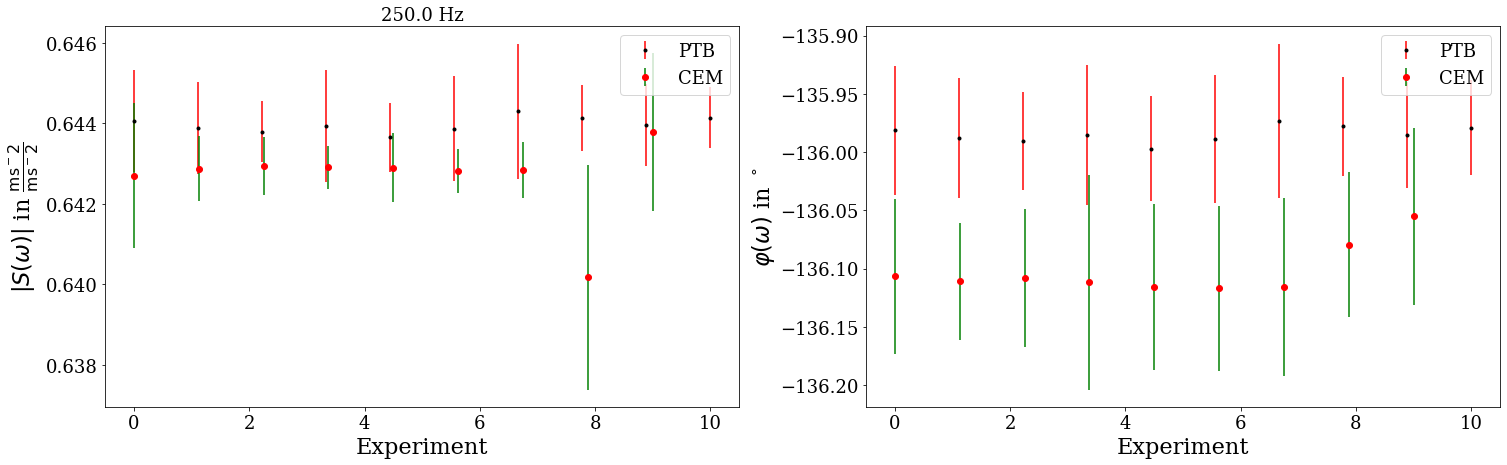

In [112]:
%matplotlib inline
#%matplotlib qt
for val1,val2 in zip(PTB_separated_by_freq.values(),CEM_separated_by_freq_new.values()):  
    plt.figure(figsize=(25,7))
    plt.subplot(1,2,1)
 
    x = np.linspace(0,len(val1[q_names[1]]),len(val1[q_names[1]]))
    dy = val1[q_names[2]].values/2
    y = val1[q_names[1]].values
    plt.xlabel("Experiment")
    plt.ylabel(r"$|S(\omega)|$ in $\frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$")
    plt.errorbar(x, y, yerr=dy, fmt='.k',ecolor='r',label="PTB")
    plt.title(str(val1[q_names[0]].values[0])+" Hz")
    
    x1 = np.linspace(0,len(val2[q_names[1]]),len(val2[q_names[1]]))
    plt.errorbar(x1,y=val2[q_names[1]].values,yerr =val2[q_names[2]].values/2,fmt='ro',ecolor='g',label="CEM")
    plt.legend()

    plt.subplot(1,2,2)
    x = np.linspace(0,len(val1[q_names[3]]),len(val1[q_names[3]]))
    dy = (val1[q_names[4]].values/np.pi*180)/2
    y = (val1[q_names[3]].values/np.pi)*180
    plt.xlabel("Experiment")
    plt.ylabel(r"$\varphi(\omega)$ in $^\circ$")
    plt.errorbar(x, y, yerr=dy, fmt='.k',ecolor='r',label="PTB")
                         
    x1 = np.linspace(0,len(val2[q_names[3]]),len(val2[q_names[3]]))
    plt.errorbar(x1,y=val2[q_names[3]].values/np.pi*180,yerr =val2[q_names[4]].values/2/np.pi*180,fmt='ro',ecolor='g',label="CEM")
    plt.legend()

    plt.legend()
    plt.show()
    
    #the phase  - its timing information is not very susceptible, similar for PTB and CEM 
#Magnitude  - The difference between CEM and PTB is not the consequence of the different calibration systems. 
#sensor is differently behaving in Spain due to the influence of the tempeerature. Also, it is cheap and the axis can be different 
#cosine error

#Magnitude - manufacturer specifies 1% of tranfer coefficient deviation. Normally, higher uncertainty is stated because 
#due to the mounting influence. (statistically + extraunc)

In [113]:
range_mag_PTB=range_mag_PTB.rename(columns={"Magnitude range, [m s^-2/m s^-2]":"Magnitude range, [m s^-2/m s^-2]-PTB"})
range_mag_CEM=range_mag_CEM.rename(columns={"Magnitude range, [m s^-2/m s^-2]":"Magnitude range, [m s^-2/m s^-2]-CEM"})
range_mag=pd.concat([range_mag_PTB, range_mag_CEM],axis=1)

range_ph_PTB=range_ph_PTB.rename(columns={"Phase range, [rad]":"Phase range, [rad]-PTB"})
range_ph_CEM=range_ph_CEM.rename(columns={"Phase range, [rad]":"Phase range, [rad]-CEM"})
range_ph=pd.concat([range_ph_PTB, range_ph_CEM],axis=1)


In [114]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

## 3.2 Coefficient of variation

The coefficient of variation represents the ratio of the standard deviation to the mean, and in that sense is a useful statistical tool for comparing the degree of variation from one dataseries to another.  The coefficient of variation (CV) was calculated as a statistical measure of the dispersion of data points in a data series around the mean.  Because each measurement cycle provides the estimated values and standard uncertainties, CV in percentages is calculated as

$$CV={\frac {\sigma _{i}}{\bar {x_{i}}}} *100 $$
,where x represents estimated magnitude/phase originating from the corresponding cycle $\sigma$ corresponds to the standard uncertainty.

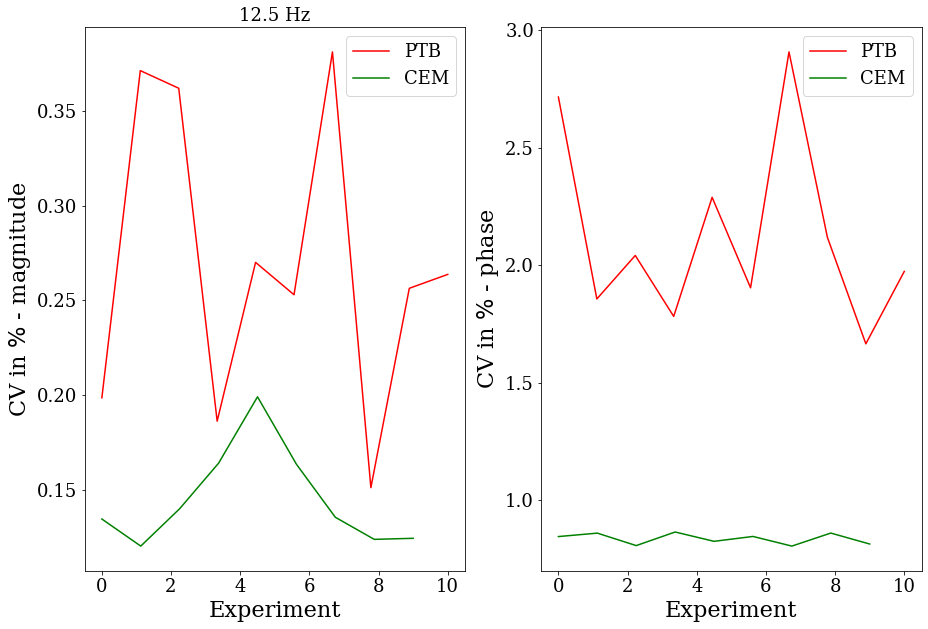

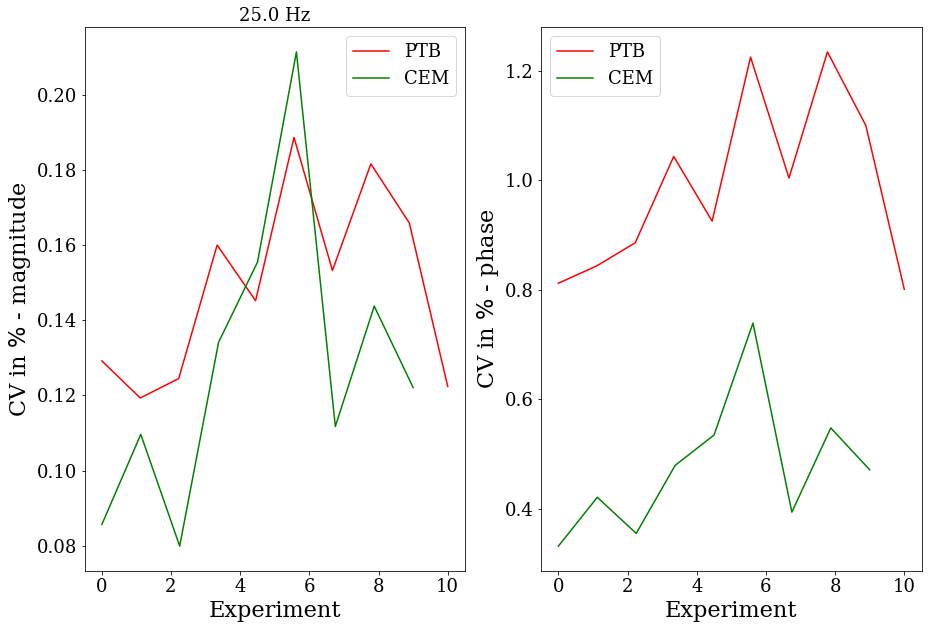

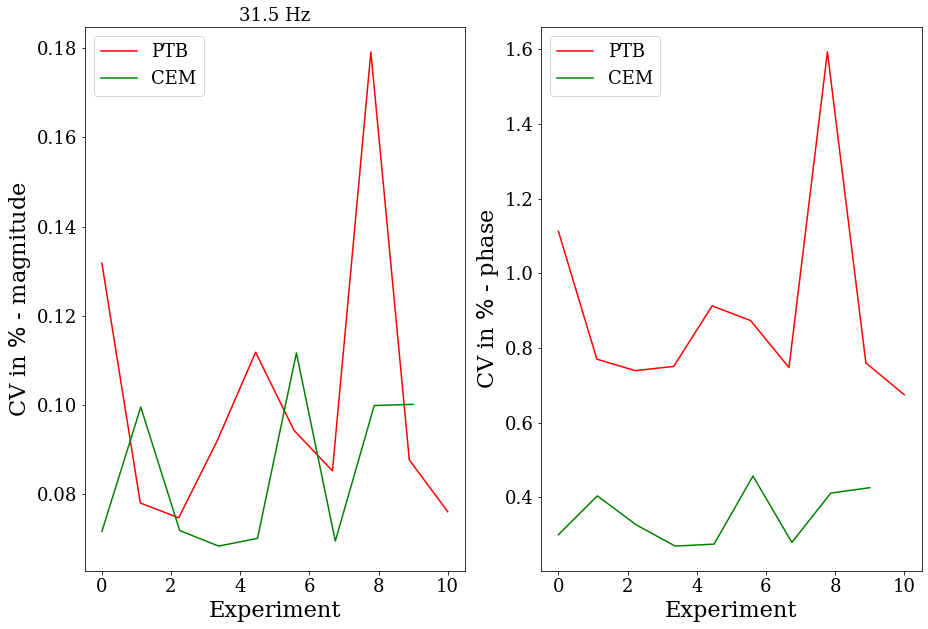

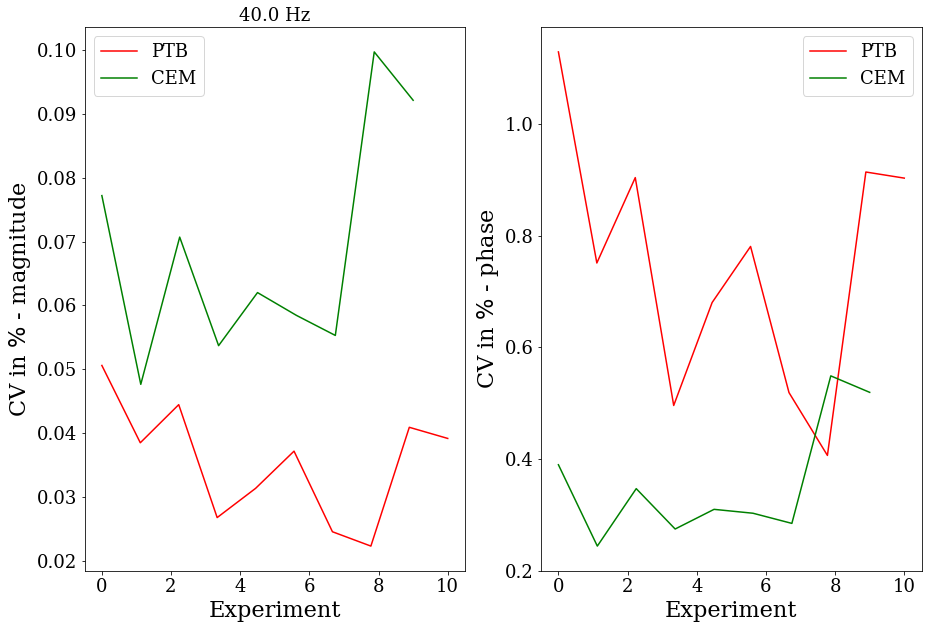

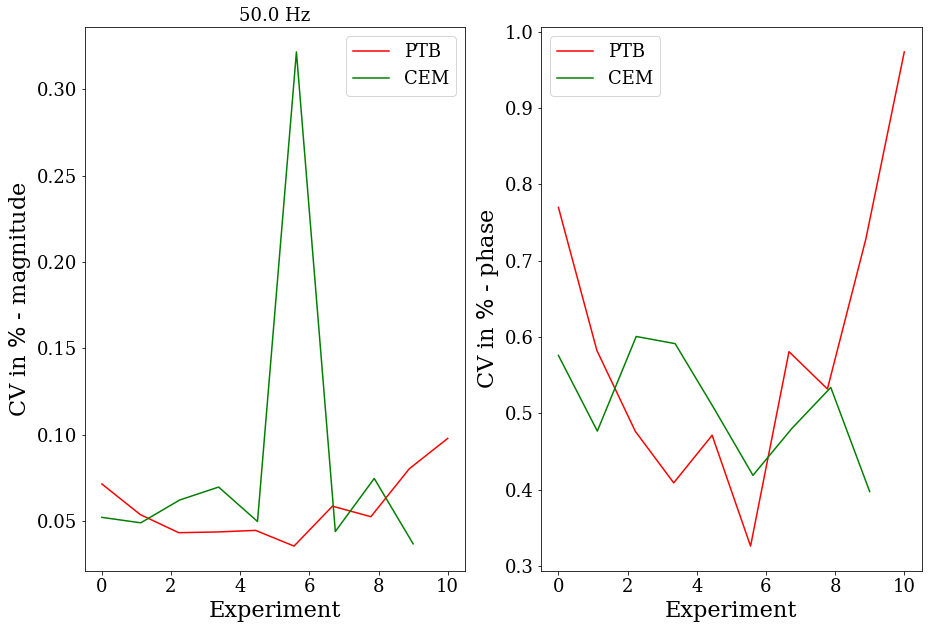

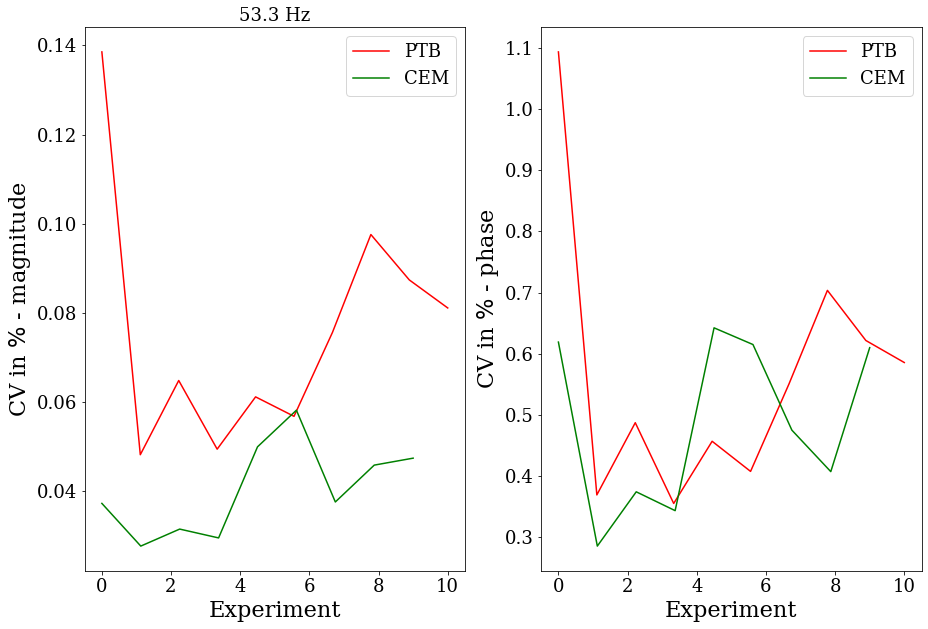

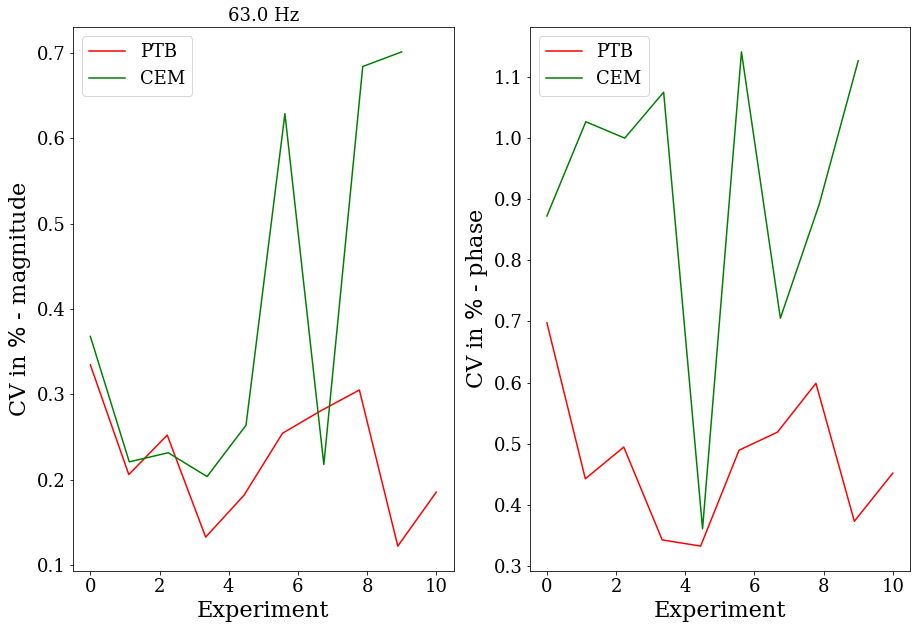

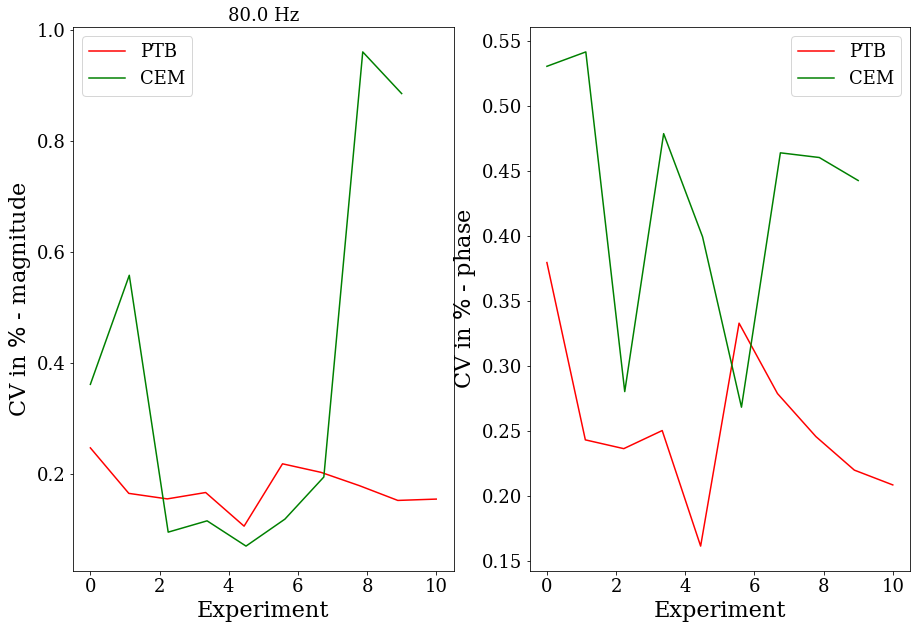

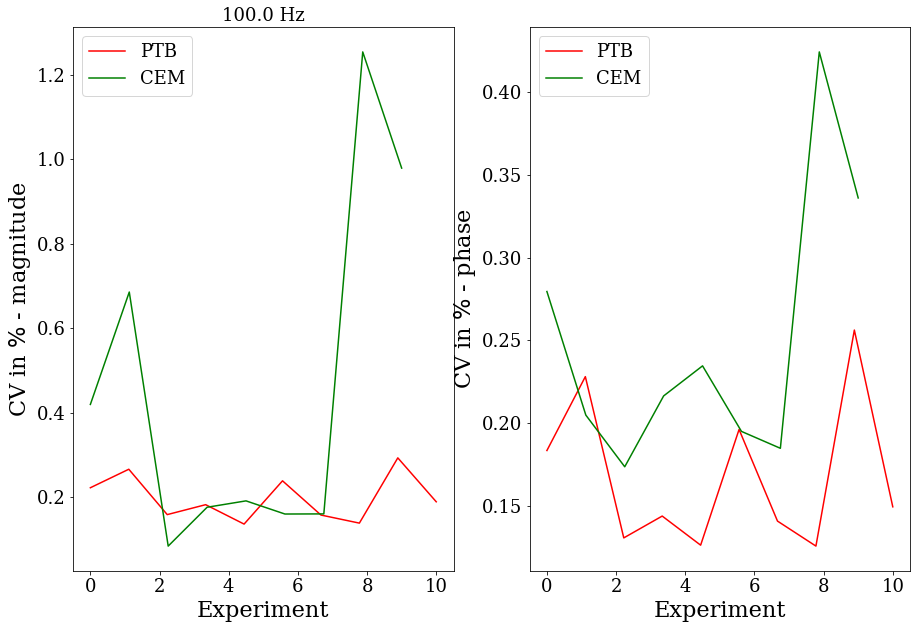

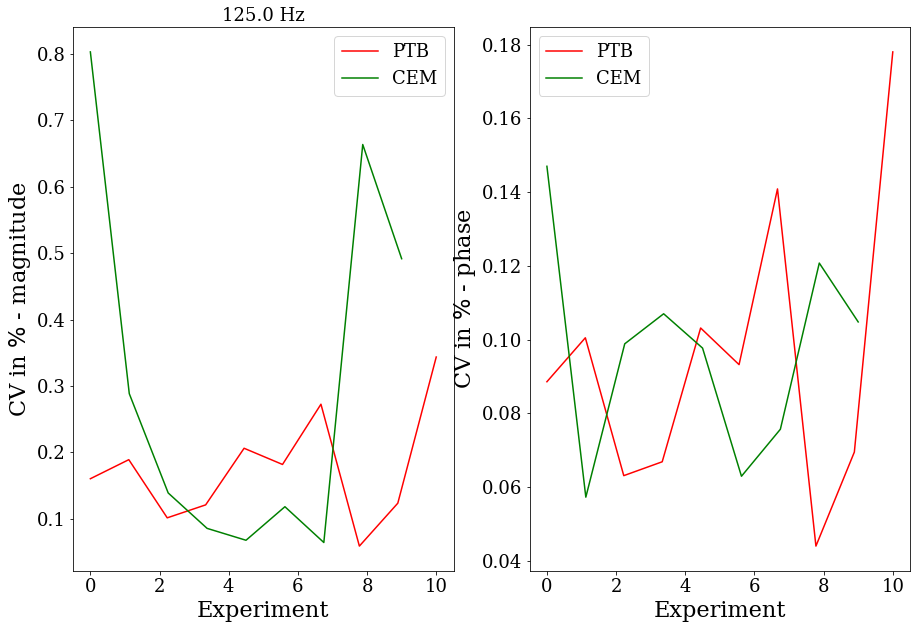

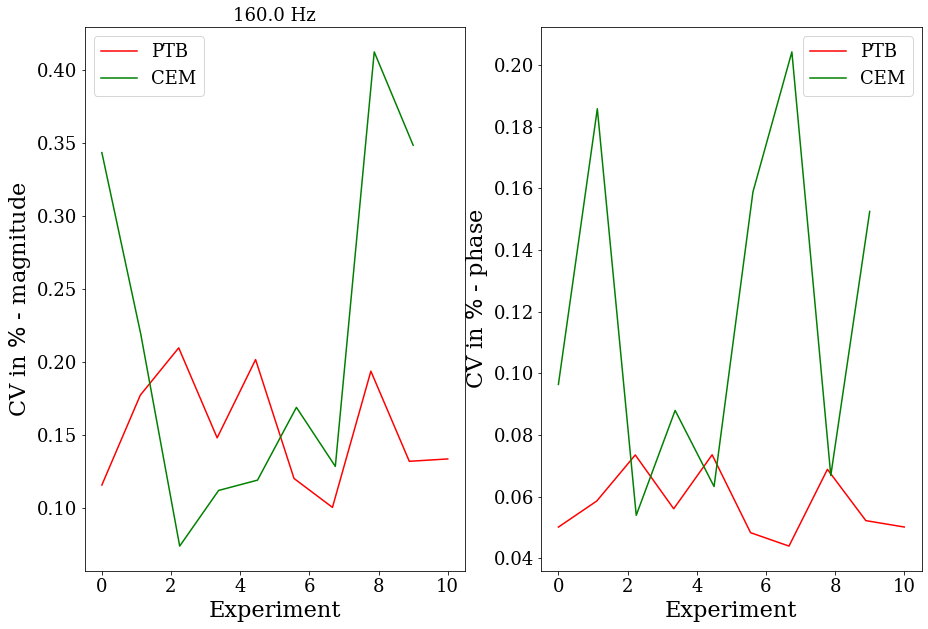

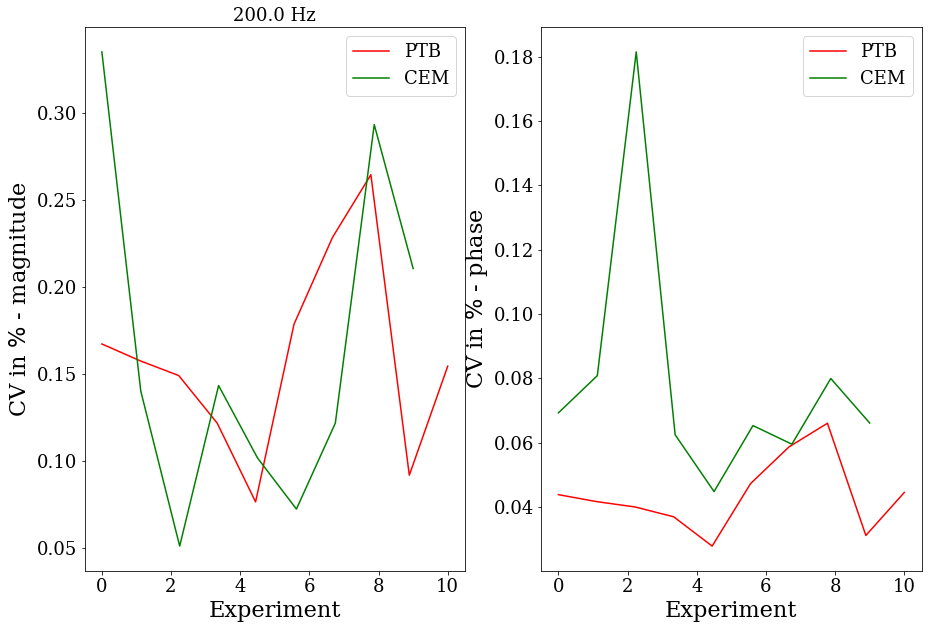

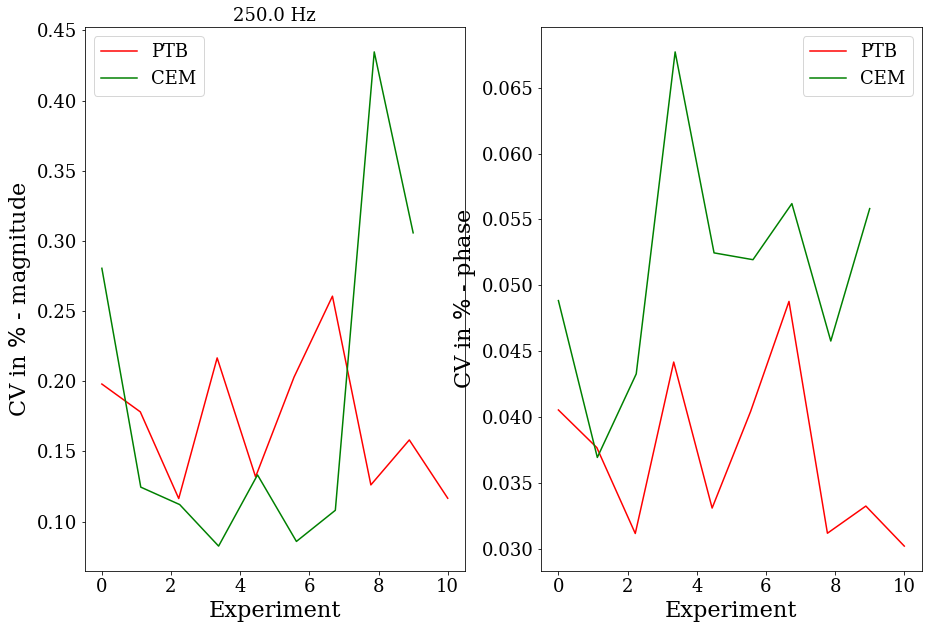

In [115]:
%matplotlib inline
for val1,val2 in zip(PTB_separated_by_freq.values(),CEM_separated_by_freq_new.values()):  
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
 
    x = np.linspace(0,len(val1[q_names[1]]),len(val1[q_names[1]]))
    y_coef = ((val1[q_names[2]].values/2)/np.abs(val1[q_names[1]].values))*100
    plt.xlabel("Experiment")
    plt.ylabel( r"CV in $\%$ - magnitude")
    plt.plot(x, y_coef,color='r',label="PTB")
    plt.title(str(val1[q_names[0]].values[0])+" Hz")
    x1 = np.linspace(0,len(val2[q_names[1]]),len(val2[q_names[1]])) 
    plt.plot(x1,((val2[q_names[2]].values/2)/np.abs(val2[q_names[1]].values))*100,color='g',label="CEM")
    plt.legend()

    plt.subplot(1,2,2)
    x = np.linspace(0,len(val1[q_names[3]]),len(val1[q_names[3]]))
    y = ((val1[q_names[4]].values/2)/np.abs(val1[q_names[3]].values))*100
    plt.xlabel("Experiment")
    plt.ylabel(  r"CV in $\%$ - phase")
    plt.plot(x, y,color='r',label="PTB")
    x1 = np.linspace(0,len(val2[q_names[4]]),len(val2[q_names[4]]))                      
    plt.plot(x1,((val2[q_names[4]].values/2)/np.abs(val2[q_names[3]].values))*100,color='g',label="CEM")
    plt.legend()
    
    plt.show()
    

Since many experiments were performed ateach calibration point, the averaged CV was calculated for both set-ups (PTB and CEM) in defined calibration range:
$${\bar {CV}={\frac{\sum _{i=1}^{n}CV _{i}}{n}}}$$
,where n represents the number of experiments at a specific frequency.

In [116]:
def calculate_mean_variation_coefficient(dictionary):
    variation_coef=np.empty((len(dictionary),3))
    for val1,i in zip(dictionary.values(),range(len(dictionary))):  
        variation_coef[i,0]=(((val1[q_names[2]].values/2)/np.abs(val1[q_names[1]].values))*100).mean()
        variation_coef[i,1]=(((val1[q_names[4]].values/2)/np.abs(val1[q_names[3]].values))*100).mean()
        variation_coef[i,2]=(((val1[q_names[7]].values/2)/np.abs(val1[q_names[6]].values))*100).mean()
    return variation_coef

In [117]:
variation_coef_PTB=calculate_mean_variation_coefficient((PTB_separated_by_freq))
variation_coef_CEM=calculate_mean_variation_coefficient((CEM_separated_by_freq_new))

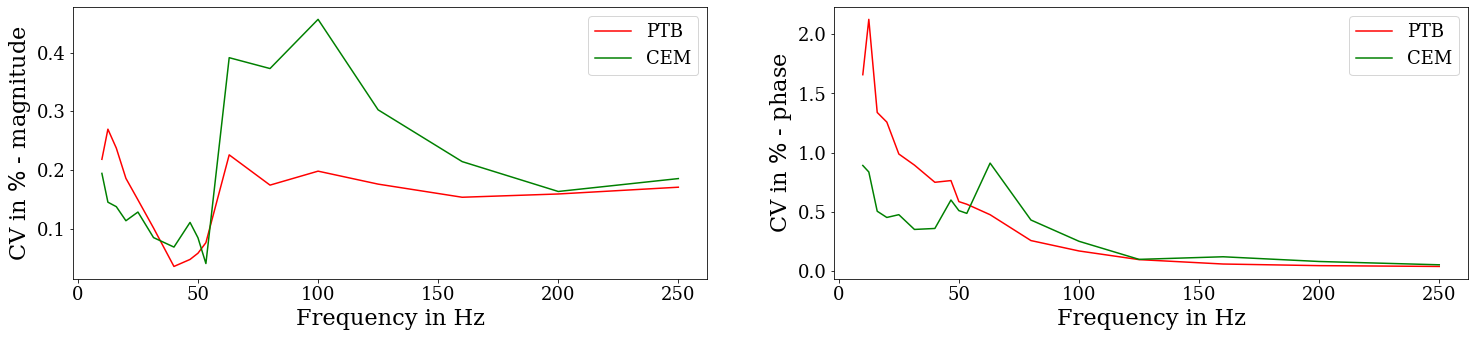

In [118]:
    %matplotlib inline
    #%matplotlib qt
    plt.figure(figsize=(25,5))
    plt.subplot(1,2,1)
    list_of_freq=[10,12.5,16,20,25,31.5,40,46.7,50,53.3,63,80,100,125,160,200,250]
    x = np.asarray(list_of_freq)
    y_coef = variation_coef_PTB[:,0]
    
    plt.xlabel("Frequency in Hz")
    plt.ylabel(r"CV in $\%$ - magnitude")
    plt.plot(x, y_coef,color='r',label="PTB")
    plt.plot(x,variation_coef_CEM[:,0],color='g',label="CEM")
    plt.legend()

    plt.subplot(1,2,2)
    x = np.asarray(list_of_freq)
    plt.xlabel("Frequency in Hz")
    plt.ylabel(r"CV in $\%$ - phase")
    plt.plot(x, variation_coef_PTB[:,1],color='r',label="PTB")
    plt.plot(x,variation_coef_CEM[:,1],color='g',label="CEM")
    plt.legend()

    plt.show()

From the graphs it is visible that the averaged CV of magnitude values for PTB’s set-up is generally lower than for CEM’s at higher frequencies.  The same appears for the phase values.  In addition to this, the averaged CV of phases varies up to 2.0 %,
whereas the averaged CV of magnitude rises to 0.4%.  The CEM’s set-up has significantly higher coefficient of variation at all calibration points in a range (63.0 - 200.0) Hz.  When observing the magnitude data, the lowest averaged CV for PTB’s setup is at 40.0 Hz and equals to 0.035%. and the lowest averaged CV for CEM’s setup, of 0.04%, corresponds to the calibration point at 53.3 Hz. The largest coefficient of variation for PTB’s setup is at 12.5 Hzand equals to 0.27%. The largest coefficient of variation for CEM is higher than 0.4% and corresponds to the calibration point of 100.0 Hz The trend of variation is similar for both laboratories. When observing phase data, CV is higher for PTB at low frequencies - up to 53.3 Hz and is decreasing at frequencies higher than 46.7 Hz while CEM’s data shows an increasing trendat frequencies between 125.0 Hz and 160.0 Hz.  The CV for both laboratories is lower at higher frequencies and show better agreement. The CV is generally higher for phase values than for magnitude values. The largest CV for PTB is 2.12% at 12.5 Hz and 0.91% at 63.0Hz for CEM.

## 3.3  The extraction of temperature data

As mentioned above, the magnitude values measured by PTB setup are always higher than for CEM. The possible source of disagreement might be related to the environmental conditions such as temperature. 

In [119]:
def extract_temp (filename, sensor_ID):
    
    with h5py.File(filename,'r') as f:
            base_items=list(f.items())
            rawtransfer=f.get("EXPERIMENTS")
            rawtransfer_items=list(rawtransfer.items())
            subgroup=rawtransfer.get("/EXPERIMENTS/Sine excitation/")
            subgroup_items=list(subgroup.items())
            temp=[None]*(len(subgroup_items))

            for i,val in enumerate(subgroup_items):
                subgroup1=rawtransfer.get("/EXPERIMENTS/Sine excitation/00"+"{0:03}".format(i)+"Sine_Excitation/"+sensor_ID+"/Temperature/")
                subgroup1=np.array(subgroup1.get("SinPOpt"))
                temp[i]=subgroup1[0,1]
            return temp

In [120]:
temp_PTB = extract_temp('MPU9250PTB_v5.hdf5',"0x1fe40000_MPU_9250")
temp_CEM = extract_temp('MPU9250CEM_v5.hdf5',"0xbccb0000_MPU_9250")

In [121]:
temp_PTB=pd.DataFrame(temp_PTB,columns=["Temperature in °C"])
temp_PTB["Frequency in Hz"]=whole_dataset_PTB["Frequency in Hz"]

In [122]:
temp_CEM=pd.DataFrame(temp_CEM,columns=["Temperature in °C"])
temp_CEM["Frequency in Hz"]=whole_dataset_CEM["Frequency in Hz"]

In [123]:
delete_rows=[]

for k in range(0,171,19):
    i=k
    j=k+1
    delete_rows.append(i)
    delete_rows.append(j)
temp_CEM_new=temp_CEM.drop(axis=0,index=delete_rows)

## 3.4 Additional analysis of magnitude and phase data 

For the further analysis, data is sorted by frequency in ascending order. Note that this analysis does not take uncertainties into account.

In [124]:
#this is for analysis in Excel
def sort_values(dataset):
    dataset=dataset.sort_values("Frequency in Hz", ascending=True)
    return dataset

In [125]:
whole_dataset_PTB=sort_values(whole_dataset_PTB)
whole_dataset_CEM=sort_values(whole_dataset_CEM_new)

In [126]:
whole_dataset_PTB.head(2)

Frequency in Hz  \
0              10.0   
51             10.0   

    $|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                            1.019554             
51                                           1.019262             

    $U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                            0.003273                 
51                                           0.005650                 

    $\varphi(\omega)$ in $rad$  $U_{\varphi(\omega)}$ in $rad$  \
0                    -0.094684                        0.003022   
51                   -0.094613                        0.003794   

    Excitation_freq in Hz  \
0                    10.0   
51                   10.0   

    $A_{excit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                               2.739           
51                                              2.749           

    $U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  
0                                            0.004891           
51                                           0.009688

In [127]:
whole_dataset_CEM.head(2)

Frequency in Hz  \
2               10.0   
135             10.0   

     $|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
2                                             1.016209             
135                                           1.018973             

     $U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
2                                             0.004893                 
135                                           0.002764                 

     $\varphi(\omega)$ in $rad$  $U_{\varphi(\omega)}$ in $rad$  \
2                     -0.094907                        0.001665   
135                   -0.095122                        0.001690   

     Excitation_freq in Hz  \
2                     10.0   
135                   10.0   

     $A_{excit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
2                                             2.754331           
135                                           2.753776           

     $U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  
2                                             0.005860           
135                                           0.003753

In order to plot magnitude and phase data in a relation to the frequency values in linear and logarithmic scale, the mean values of all experiments are calculated and stored in variables: *whole_dataset_PTB_groupby* and *whole_dataset_CEM_groupby*  

In [128]:
whole_dataset_PTB_groupby=whole_dataset_PTB.groupby(['Frequency in Hz']).mean()
whole_dataset_CEM_groupby=whole_dataset_CEM.groupby(['Frequency in Hz']).mean()

In [129]:
whole_dataset_PTB["Lab"]="PTB"
whole_dataset_CEM["Lab"]="CEM"
whole_dataset_PTB_groupby["Lab"]="PTB"
whole_dataset_CEM_groupby["Lab"]="CEM"

In [130]:
result = pd.concat([whole_dataset_PTB,whole_dataset_CEM])
result_groupby= pd.concat([whole_dataset_PTB_groupby,whole_dataset_CEM_groupby])

## 3.5 The effect of environmental temperature on magnitude and phase

Indeed, the initial assessment points out that ambient temperature was higher in the PTB’s laboratory than in CEM’s. Moreover, digital sensors have an integrated temperature sensor which could cause some influence on the quantities of an interest.

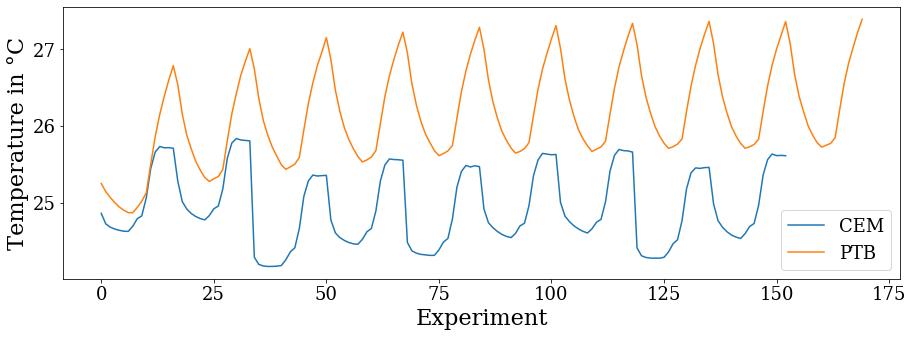

In [131]:
#takes some time tu run because of a huge number of points
plt.figure(figsize=(15,5))
ax = plt.axes()
sns.lineplot(x=np.arange(len(temp_CEM_new)), y=temp_CEM_new["Temperature in °C"].values,ax=ax, label="CEM")
sns.lineplot(x=np.arange(len(temp_PTB)), y=temp_PTB["Temperature in °C"].values,ax=ax, label="PTB")
plt.xlabel("Experiment")
plt.ylabel("Temperature in °C")
plt.legend()                         
plt.show()

In [132]:
temp_2_PTB=pd.concat([whole_dataset_PTB,temp_PTB["Temperature in °C"]],axis=1)
temp_2_CEM=pd.concat([whole_dataset_CEM_new,temp_CEM_new["Temperature in °C"]],axis=1)

The position of the temperature sensor must be taken into consideration. If the temperature is not affected by the presence of people, the change of magnitude and phase shows opposite behaviour in a relation to the change of temperature.  At this step, this conclusion is not reliable because the temeprature is an independent variable, whereas the magnitude and phase are dependant on calibration procedure. 

In [133]:
%matplotlib inline
def plot_vs_temp(data,col1,col2,label,lab):
    plt.figure(figsize=(10,5))
    data[col1].plot(label="Temperature in °C",legend=True)
    plt.ylabel("Temperature in °C")
    data[col2].plot(secondary_y=True, label=r"$|S(\omega)|$ in $\frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",legend=True)
    plt.xlabel("Experiment")
    plt.ylabel(r"$|S(\omega)|$ in $\frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$")
    plt.title(lab)
    plt.show()

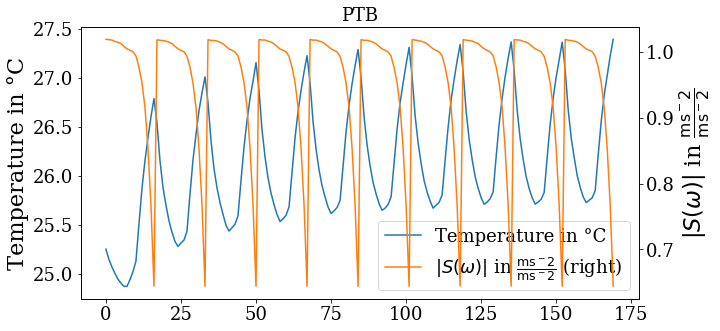

In [134]:
plot_vs_temp(temp_2_PTB,"Temperature in °C",r"$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",r"$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$","PTB")

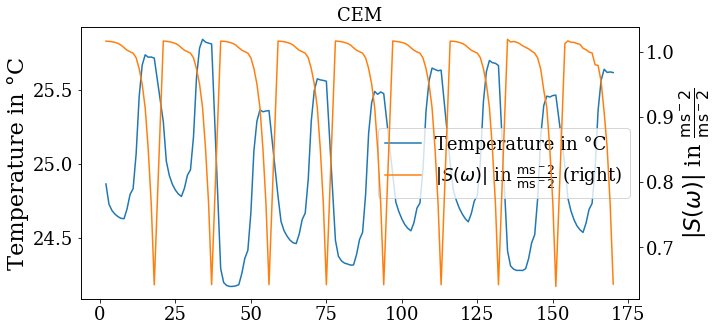

In [135]:
plot_vs_temp(temp_2_CEM,"Temperature in °C",r"$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",r"$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$","CEM")

In [136]:
def plot_vs_temp_2(data,col1,col2,label,lab):
    plt.figure(figsize=(10,5))
    data[col1].plot(label="Temperature in °C", legend=True,figsize=(15,5))
    plt.ylabel("Temperature in °C",fontsize=14)
    data[col2]=np.rad2deg(data[col2].values)
    data[col2].plot(secondary_y=True, label=label, legend=True)
    plt.xlabel("Experiment",fontsize=14)
    plt.ylabel(label,fontsize=14)
    plt.title(lab,fontsize=14)
    plt.show()

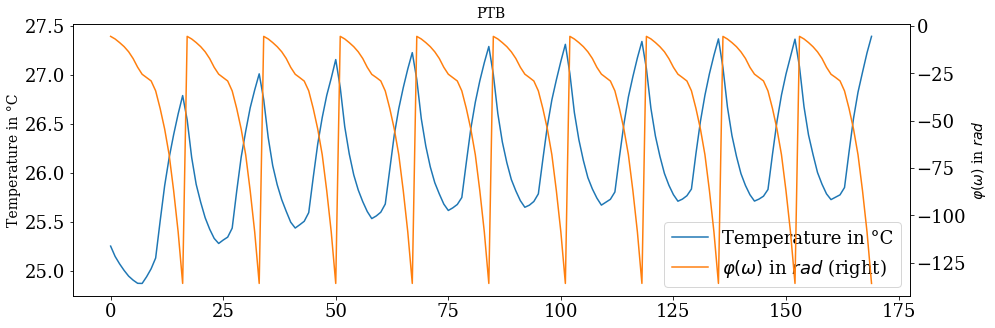

In [137]:
plot_vs_temp_2(temp_2_PTB,"Temperature in °C",r"$\varphi(\omega)$ in $rad$",r"$\varphi(\omega)$ in $rad$","PTB")

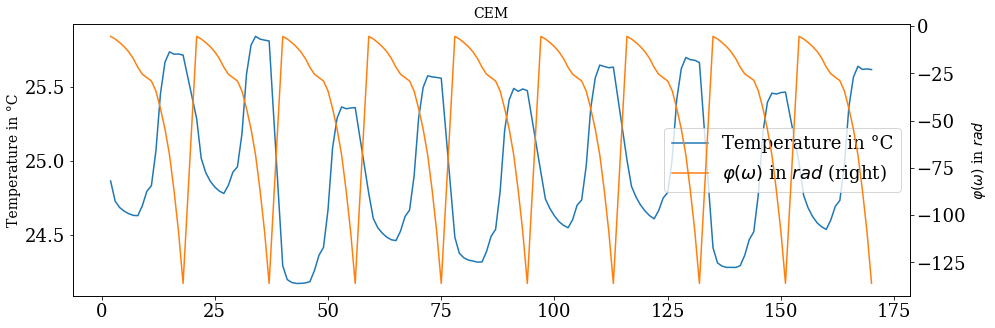

In [138]:
plot_vs_temp_2(temp_2_CEM,"Temperature in °C",r"$\varphi(\omega)$ in $rad$",r"$\varphi(\omega)$ in $rad$","CEM")

In [139]:
temp_2_PTB=temp_2_PTB.sort_values(by=["Frequency in Hz"])
temp_2_CEM=temp_2_CEM.sort_values(by=["Frequency in Hz"])

The Pearson correlation coefficients  between:
<br> magnitude and temeperature and 
<br> phase and temperature 

are calculated at each frequency for PTB and CEM. The correlation coefficients are mostly negative, which are in line with the previous statement about the opposite behaviour. The correlation can be further examined by significance testing (p-value can be calculated). However, some guidelines for the values of correlation coefficients have been found in literature and shown on the Figure below:
    
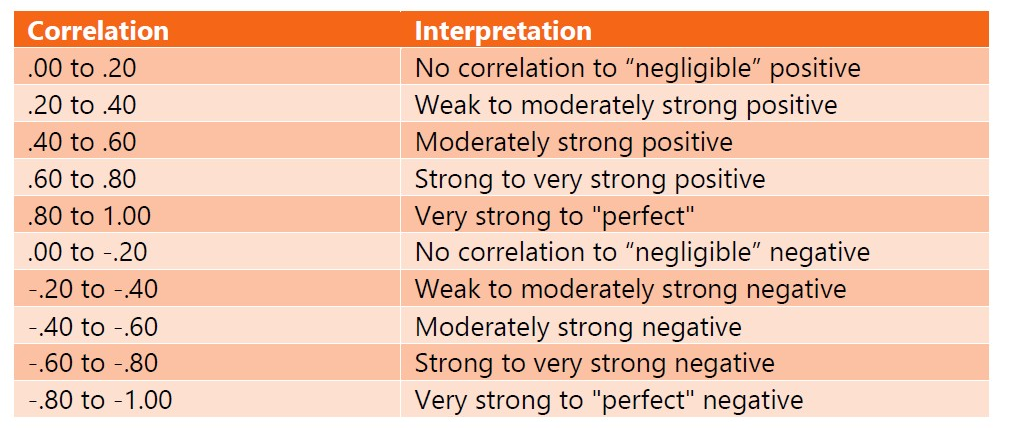
   

In [140]:
def Pearson_correlation(data,col1,col2):
    list_freq=data["Frequency in Hz"].unique()
    corr_coef=np.zeros(len(list_freq))
    ci=np.zeros((len(list_freq),2))
    pval=np.zeros(len(list_freq))
    for i,val in enumerate(list_freq):
        data1=data.loc[data["Frequency in Hz"].values==val,:]
        corr_coef[i],pval[i] = stats.pearsonr(data1[col1].values,data1[col2].values)
        se = 1/np.sqrt(len(data1)-3)
        r_z = np.arctanh(corr_coef[i])
        alpha = 0.05
        z = stats.norm.ppf(1-alpha/2)
        lo_z, hi_z = r_z-z*se, r_z+z*se
        lo, hi = np.tanh((lo_z, hi_z))
        ci[i,0]=lo
        ci[i,1]=hi
    return corr_coef,ci,pval

In [141]:
corr_magnitude=np.zeros((len(temp_2_PTB["Frequency in Hz"].unique()),2))
corr_magnitude[:,0],ci_PTB_magnitude,p_PTB_magnitude=Pearson_correlation(temp_2_PTB,"Temperature in °C",r"$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$")
corr_magnitude[:,1],ci_CEM_magnitude,p_CEM_magnitude=Pearson_correlation(temp_2_CEM,"Temperature in °C",r"$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$")
corr_magnitude=pd.DataFrame(corr_magnitude, columns=["PTB","CEM"],index=temp_2_PTB["Frequency in Hz"].unique())

The lower and upper limits of a confidence interval for correlation coefficients have different sign at all frequencies except 40.0 Hz  for PTB and at all frequencies except 160.0 Hz for CEM which means that it cannot be fully accepted that the correlation is negative.

In [142]:
CI_val=np.concatenate((ci_PTB_magnitude,ci_CEM_magnitude),axis=1)
CI_val_magnitude=pd.DataFrame(CI_val,columns=['PTB_lower','PTB_upper','CEM_lower', "CEM_upper"], index=temp_2_PTB["Frequency in Hz"].unique())

In [143]:
CI_val_magnitude

PTB_lower  PTB_upper  CEM_lower  CEM_upper
10.0   -0.881991   0.096629  -0.841292   0.358119
12.5   -0.856712   0.198088  -0.392242   0.829290
16.0   -0.749646   0.469514  -0.829879   0.390640
20.0   -0.153151   0.868570  -0.889144   0.180482
25.0   -0.550248   0.697727  -0.644541   0.682832
31.5   -0.897486   0.022449  -0.460547   0.801323
40.0   -0.932727  -0.194849  -0.828042   0.395605
46.7   -0.805704   0.351306  -0.821439   0.412880
50.0   -0.496885   0.733579  -0.837421   0.369486
53.3   -0.806076   0.350375  -0.583552   0.731744
63.0   -0.794944   0.377268  -0.700755   0.623996
80.0   -0.648251   0.610248  -0.633123   0.692994
100.0  -0.713469   0.528008  -0.428739   0.815071
125.0  -0.713230   0.528359  -0.739045   0.572969
160.0  -0.816944   0.322139  -0.742901   0.567197
200.0  -0.769263   0.432585  -0.778086   0.507830
250.0  -0.522176   0.717400  -0.466815   0.798447

Additional check is made by the calculation of the p-value. p-value evaluates how well the data rejects the null hypothesis, which states that there is no relationship between two compared groups. Successfully rejecting this hypothesis tells that results may be statistically significant.  Alpha is usually set to 0.05, meaning the probability of achieving the same or more extreme results assuming the null hypothesis is 5%. If the p-value is less than the specified alpha value, the null hypothesis is rejected.

In [144]:
p_val_magnitude=np.zeros((len(p_PTB_magnitude),2))
p_val_magnitude[:,0]=p_PTB_magnitude
p_val_magnitude[:,1]=p_CEM_magnitude

p_val_magnitude=pd.DataFrame(p_val_magnitude,columns=['PTB', "CEM"], index=temp_2_PTB["Frequency in Hz"].unique())
p_val_magnitude.style.applymap(lambda x: 'background-color : green' if x<0.05 else 'background-color : red')

The null hypothesis that states that there is no relationships between magnitude and temperature can be rejected at frequencies 40.0 Hz and for PTB  and at 160.0 Hz for CEM because the p-values are less than 0.05. 

In [145]:
corr_magnitude.head(2)

PTB       CEM
10.0 -0.567526 -0.401491
12.5 -0.493030  0.367652

The same procedure is now applied to the examination of the relationship between phase values and temperature.

In [146]:
corr_phase=np.zeros((len(temp_2_PTB["Frequency in Hz"].unique()),2))
corr_phase[:,0],ci_PTB_phase,p_PTB_phase=Pearson_correlation(temp_2_PTB,"Temperature in °C",r"$\varphi(\omega)$ in $rad$")
corr_phase[:,1],ci_CEM_phase,p_CEM_phase=Pearson_correlation(temp_2_CEM,"Temperature in °C",r"$\varphi(\omega)$ in $rad$")
corr_phase=pd.DataFrame(corr_phase, columns=["PTB","CEM"],index=temp_2_PTB["Frequency in Hz"].unique())

In [147]:
corr_phase.head(2)

PTB       CEM
10.0 -0.170593  0.384971
12.5  0.038267 -0.059389

In [148]:
CI_val=np.concatenate((ci_PTB_phase,ci_CEM_phase),axis=1)
CI_val_phase=pd.DataFrame(CI_val,columns=['PTB_lower','PTB_upper','CEM_lower', "CEM_upper"], index=temp_2_PTB["Frequency in Hz"].unique())

In [149]:
CI_val_phase.head()

PTB_lower  PTB_upper  CEM_lower  CEM_upper
10.0  -0.722604   0.514271  -0.375035   0.835486
12.5  -0.605959   0.652180  -0.696057   0.629564
16.0  -0.461910   0.753869  -0.683059   0.644292
20.0  -0.905676  -0.021332  -0.639565   0.687325
25.0  -0.860986   0.182385  -0.565965   0.743713

In [150]:
p_val_phase=np.zeros((len(p_PTB_phase),2))
p_val_phase[:,0]=p_PTB_phase
p_val_phase[:,1]=p_CEM_phase

p_val_phase=pd.DataFrame(p_val_phase,columns=['PTB', "CEM"], index=temp_2_PTB["Frequency in Hz"].unique())
p_val_phase.style.applymap(lambda x: 'background-color : green' if x<0.05 else 'background-color : red')

The null hypothesis that states that there is no relationships between phase and temperature can be rejected only at a frequencies of 20.0 Hz and 50.0 Hz for PTB because the p-value is less than 0.05.

## 3.5.1 The correlation from sampling

From introduction plots in 3.1, it can be visible that data of interest for PTB and CEM is overlapping once when uncertainties are included. The previous correlation coefficients have not included the influence of uncertainties. In order to see the effect of uncertainties on correlation coefficients, data is sampled from the normal distribution defined by the mean value at a specific experiment and its standard deviation - given as the expanded uncertainty divided by 2. Then, the mean correlation coefficient is calculated. This is built as some kind of an abbreviated Monte Carlo method and performed for the joint data only, but can be applied for the separate conditions for PTB and CEM.

In [151]:
def Pearson_correlation_sampling(data,col1,col2,col3):
    list_freq=data["Frequency in Hz"].unique()
    corr_coef=np.zeros(len(list_freq))
    for i,val in enumerate(list_freq):
        data1=data.loc[data["Frequency in Hz"].values==val,:]
        corr_coef1=np.zeros(50)
        x=np.zeros((len(data1),50))
        for a,item in enumerate(data1.index):
            x[a,:]=np.random.normal(data1[col2].values[a],data1[col3].values[a]/2,50)
        for col in range(x.shape[1]):
            corr_coef1[col],_ = stats.pearsonr(data1[col1].values,x[:,col])
        corr_coef[i]=corr_coef1.mean()
    return corr_coef

In [152]:
corr_magnitude_sampled_PTB=np.zeros(len(temp_2_PTB["Frequency in Hz"].unique()))
corr_magnitude_sampled_PTB=Pearson_correlation_sampling(temp_2_PTB,"Temperature in °C",r"$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",r"$U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$")

In [153]:
corr_phase_sampled_PTB=np.zeros(len(temp_2_PTB["Frequency in Hz"].unique()))
corr_phase_sampled_PTB=Pearson_correlation_sampling(temp_2_PTB,"Temperature in °C",r"$\varphi(\omega)$ in $rad$",r"$U_{\varphi(\omega)}$ in $rad$")

In [154]:
corr_magnitude_sampled_PTB

array([ 0.06112333, -0.11718878, -0.00892851,  0.09846718, -0.03111179,
       -0.24703472, -0.06678044,  0.03940821, -0.03563884, -0.00736946,
       -0.12391233,  0.04622026, -0.03244945,  0.03450966, -0.03482823,
       -0.09075691, -0.00997831])

In [155]:
corr_phase_sampled_PTB

array([-0.1495489 ,  0.02954883,  0.23867709, -0.64393813, -0.50912385,
        0.32643118, -0.49723888,  0.3312554 ,  0.64127452,  0.03699503,
       -0.20640896,  0.12081597, -0.11660568,  0.08447332, -0.32429629,
       -0.23348408,  0.13859953])

In [156]:
corr_magnitude_sampled_CEM=np.zeros(len(temp_2_CEM["Frequency in Hz"].unique()))
corr_magnitude_sampled_CEM=Pearson_correlation_sampling(temp_2_CEM,"Temperature in °C",r"$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",r"$U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$")

In [157]:
corr_phase_sampled_CEM=np.zeros(len(temp_2_CEM["Frequency in Hz"].unique()))
corr_phase_sampled_CEM=Pearson_correlation_sampling(temp_2_CEM,"Temperature in °C",r"$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",r"$U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$")

In [158]:
corr_magnitude_sampled_CEM

array([-0.26380395,  0.10556793, -0.20347849, -0.06853065,  0.01450507,
        0.13950621, -0.17947064, -0.21009612, -0.15430239,  0.01095229,
       -0.00852439, -0.02273865,  0.16445627, -0.10792777, -0.05044608,
       -0.00362463,  0.10444723])

In [159]:
corr_phase_sampled_CEM

array([-0.32332785,  0.03251689, -0.08589956, -0.00443073,  0.02046733,
        0.14196496, -0.08195097, -0.26317889, -0.1457922 , -0.0106404 ,
       -0.05917395,  0.03327277,  0.12791593, -0.06804232, -0.02457052,
       -0.0867004 ,  0.17681564])

According to this analysis, the correlation between magnitude and temperature  and between phase and temperature for both laboratories is negligible.

# 8. Datasets for the Excel validation

In [160]:
writer2 = pd.ExcelWriter('All_datasets.xlsx')

whole_dataset_CEM.to_excel(writer2, sheet_name = 'CEM', index = False)
whole_dataset_PTB.to_excel(writer2, sheet_name = 'PTB', index = False)

writer2.save()

# References

 https://www.investopedia.com/terms/c/coefficientofvariation.asp
<br>https://en.wikipedia.org/wiki/Weighted_arithmetic_mean
<br>https://en.wikipedia.org/wiki/Effective_sample_size
<br>https://online.stat.psu.edu/stat500/lesson/10/10.2/10.2.1
<br>https://www.marsja.se/levenes-bartletts-test-of-equality-homogeneity-of-variance-in-python/
<br>https://en.wikipedia.org/wiki/Weighted_arithmetic_mean
<br>https://en.wikipedia.org/wiki/Effective_sample_size
<br>https://online.stat.psu.edu/stat500/lesson/10/10.2/10.2.1
<br>https://iopscience.iop.org/article/10.1088/0026-1394/39/6/10